# **MOUNT GOOGLE DRIVE**

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    project_directory = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/'  # Change this path to match your Google Drive directory
    os.chdir(project_directory)
except:
    pass


Mounted at /content/drive


a. Summary, At a Glance

Task: Arrhythmia Classification, 5 classes
Dataset: MIT-BIH ECG dataset, Dataset website: Here
Model: CNN_LSTM with Attention

b. Information about Dataset:

1.   The MIT-BIH dataset contains 48 readings.
2.   Number of patients = 47 (25 Men, 22 Women). Only 1 patient has 2 readings. Rest 1 readings/patients.
3. Each reading contains a. ECG signals b. Annotations
4. ECG signals length = 30 Minutes (or slightly over). Sampling Frequency = 360 Hz.
5. Each reading contains 2 Lead ECG signals that are Modified Limb Lead II and Modified Lead V1 (Occationally V2, V5, V4 just only once). Simply, Two Leads: MLII, V1.
6. Annotation is given for each beat. Although 20 types of beats are annotated in dataset. We consider only 15 types of beats grouped in 5 classes followed by the recommendation of AAMI.



*   N - Normal
*   S - Supraventricular premature beat
*   V - Premature ventricular contraction
*F - Fusion of ventricular and normal beat
*Q - Unclassifiable / Unknown beat

Additional Dataset Information:

The source of the ECGs included in the MIT-BIH Arrhythmia Database is a set of over 4000 long-term Holter recordings that were obtained by the Beth Israel Hospital Arrhythmia Laboratory between 1975 and 1979. Approximately 60% of these recordings were obtained from inpatients. The subjects were 25 men aged 32 to 89 years, and 22 women aged 23 to 89 years

# **Part A: Installing Packages and Basic Visualization of ECG**

In [ ]:
!pip install wfdb
!pip install PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.5 MB/s eta 0:00:00


In [ ]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [ ]:
RECORDS = r"/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/RECORDS"
patient_ids = pd.read_csv(RECORDS, header=None, engine="python").to_numpy().reshape(-1)
patient_ids


array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

In [ ]:
DATA_ROOT = r"/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0"

In [ ]:
#Extracting just 1 patient ECG signal and info
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

In [ ]:
# {
#     'fs': 360,                # Sampling frequency in Hz
#     'sig_len': 650000,        # Length of the signal (number of samples)
#     'n_sig': 2,               # Number of signals (leads)
#     'base_date': None,        # No base date provided
#     'base_time': None,        # No base time provided
#     'units': ['mV', 'mV'],    # Units for the leads (millivolts)
#     'sig_name': ['MLII', 'V5'],  # Names of the signals (MLII and V5)
#     'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']  # Comments regarding the patient and medications
# }

<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


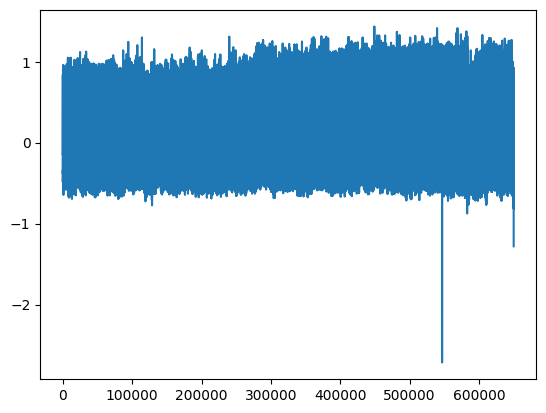

In [ ]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
plt.plot(lead0[100])
print(info)


In [ ]:
# To visualize a portion of the ECG signal over a one-second interval, we extract the first 3000 samples
# (since the sampling frequency is 360 Hz, this corresponds to about 8.33 seconds of data).

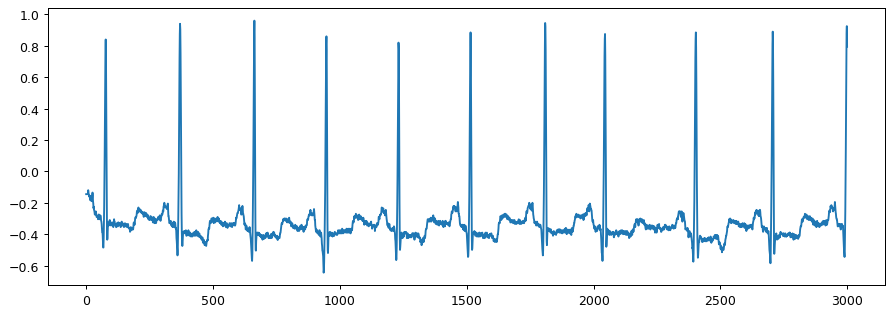

In [ ]:
# ECG signal per second
a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

In [ ]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [ ]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [ ]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

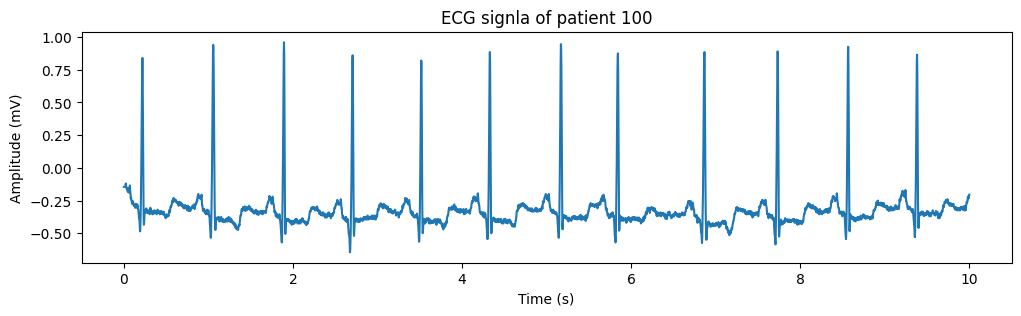

In [ ]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [ ]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

# **Part B: Denoising, R-Peak Detection, Segmentation**

In [ ]:
project_path = r"/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/"

In [ ]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

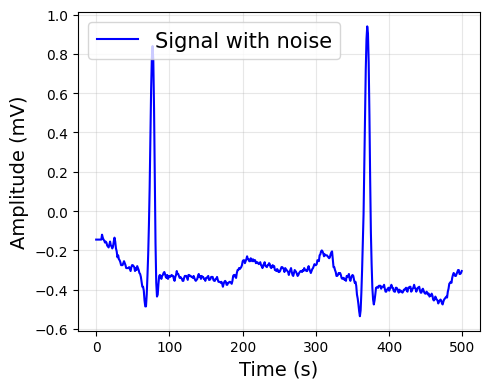

In [ ]:
# Plotting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()

plt.figure(figsize=(5,4))  # Set the figure size
plt.plot(data[0:500], label="Signal with noise", color="blue")  # Add label and color
plt.xlabel("Time (s)", fontsize=14)  # Add x-axis label
plt.ylabel("Amplitude (mV)", fontsize=14)  # Add y-axis label
plt.legend(fontsize=15)  # Add legend with font size
plt.grid(alpha=0.3)  # Optional: Add grid for better visualization
plt.tight_layout()  # Adjust layout for clarity
plt.show()  # Display the plot


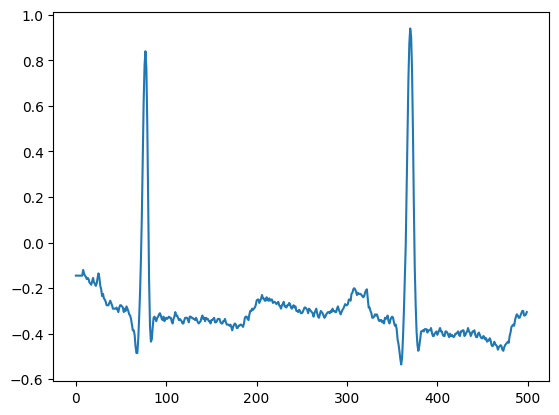

In [ ]:
# Ploting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

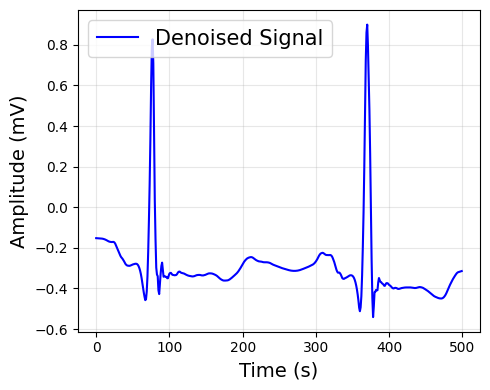

In [ ]:
# Plotting the same signal after denoising
rdata = denoise(data=data)

plt.figure(figsize=(5, 4))  # Set the figure size
plt.plot(rdata[0:500], label="Denoised Signal", color="blue")  # Add label and color
plt.xlabel("Time (s)", fontsize=14)  # Add x-axis label
plt.ylabel("Amplitude (mV)", fontsize=14)  # Add y-axis label
plt.legend(fontsize=15, loc='upper left')  # Add legend with font size
plt.grid(alpha=0.3)  # Optional: Add grid for better visualization
plt.tight_layout()  # Adjust layout for clarity
plt.show()  # Display the plot


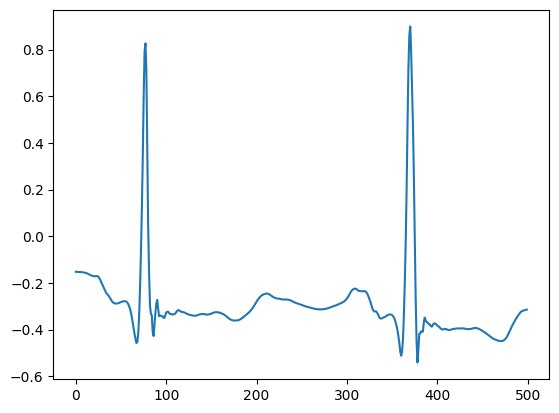

In [ ]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

In [ ]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [ ]:
len(annotation.symbol)

2274

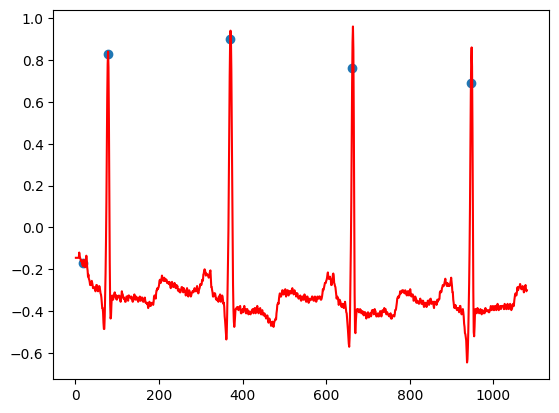

In [ ]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

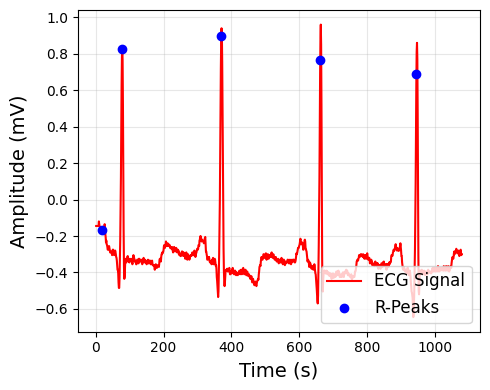

In [ ]:
# R-peak plotting with legend, x-axis, and y-axis labels
x = np.arange(1, 1081)  # Define x-axis range for the plot

n_peak = 5  # Number of R-peaks to plot
r_peak_x = []
r_peak_y = []

# Extract R-peak locations and corresponding amplitudes
for i in range(0, n_peak):
    r_peak_x.append(Rlocation[i])
    r_peak_y.append(rdata[Rlocation[i]])

# Plot the ECG signal
plt.figure(figsize=(5, 4))  # Set figure size
plt.plot(x, data[0:1080], color='red', label="ECG Signal")  # Plot signal with label

# Scatter plot for R-peaks
plt.scatter(r_peak_x, r_peak_y, color='blue', label="R-Peaks", zorder=5)

# Add legend, title, and labels

plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amplitude (mV)", fontsize=14)
plt.legend(loc="lower right", fontsize=12)  # Place legend at the bottom right
plt.grid(alpha=0.3)  # Optional: Add grid for clarity
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

In [ ]:
# It takes a slice of the signal from Rlocation[i] - 99 to Rlocation[i] + 201.
# This means it extracts 99 samples before the R-peak and 201 samples after the R-peak,
# resulting in a total of 301 samples (99 + 1 + 201).
# This slice represents a single heartbeat centered around the R-peak.


(300,)
(300,)
(300,)


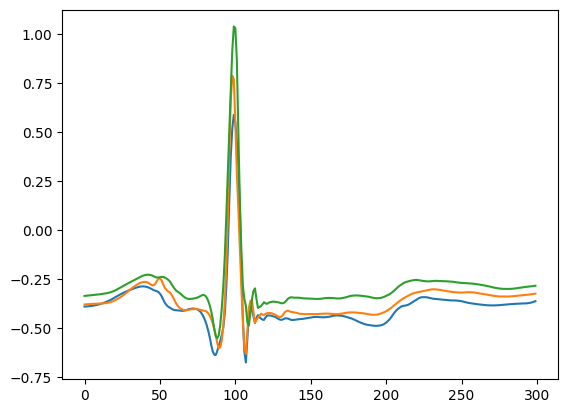

In [ ]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

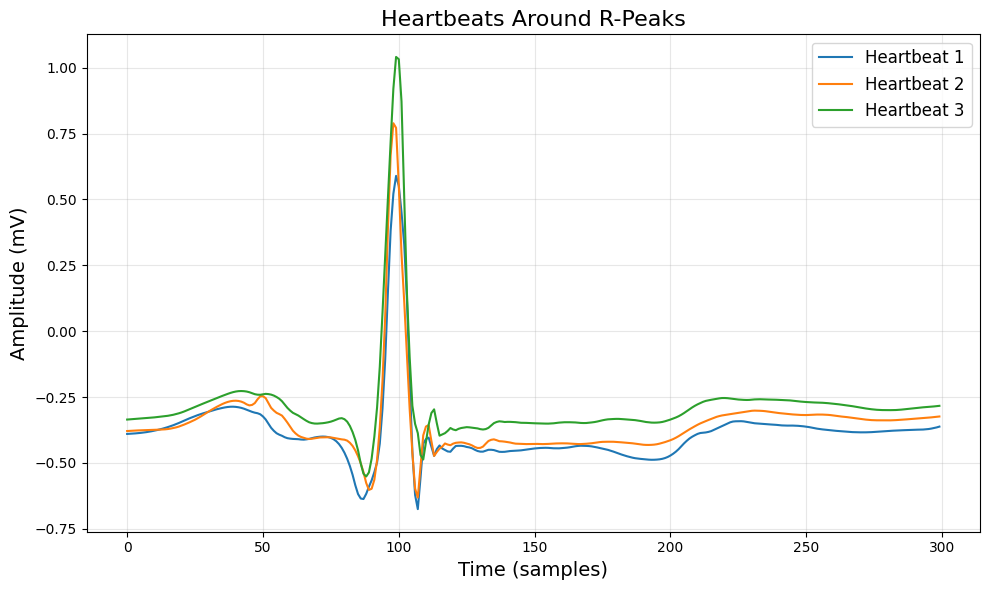

In [ ]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
plt.figure(figsize=(10, 6))  # Set figure size for better visibility

for i in k:
    # Extract segment of heartbeat around R-location
    x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
    plt.plot(x_train, label=f"Heartbeat {i - 99}")  # Label each heartbeat

# Add title, x-axis, and y-axis labels
plt.title("Heartbeats Around R-Peaks", fontsize=16)
plt.xlabel("Time (samples)", fontsize=14)
plt.ylabel("Amplitude (mV)", fontsize=14)

# Add legend, placed at the upper right
plt.legend(loc="upper right", fontsize=12)

# Optional: Add grid for clarity
plt.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

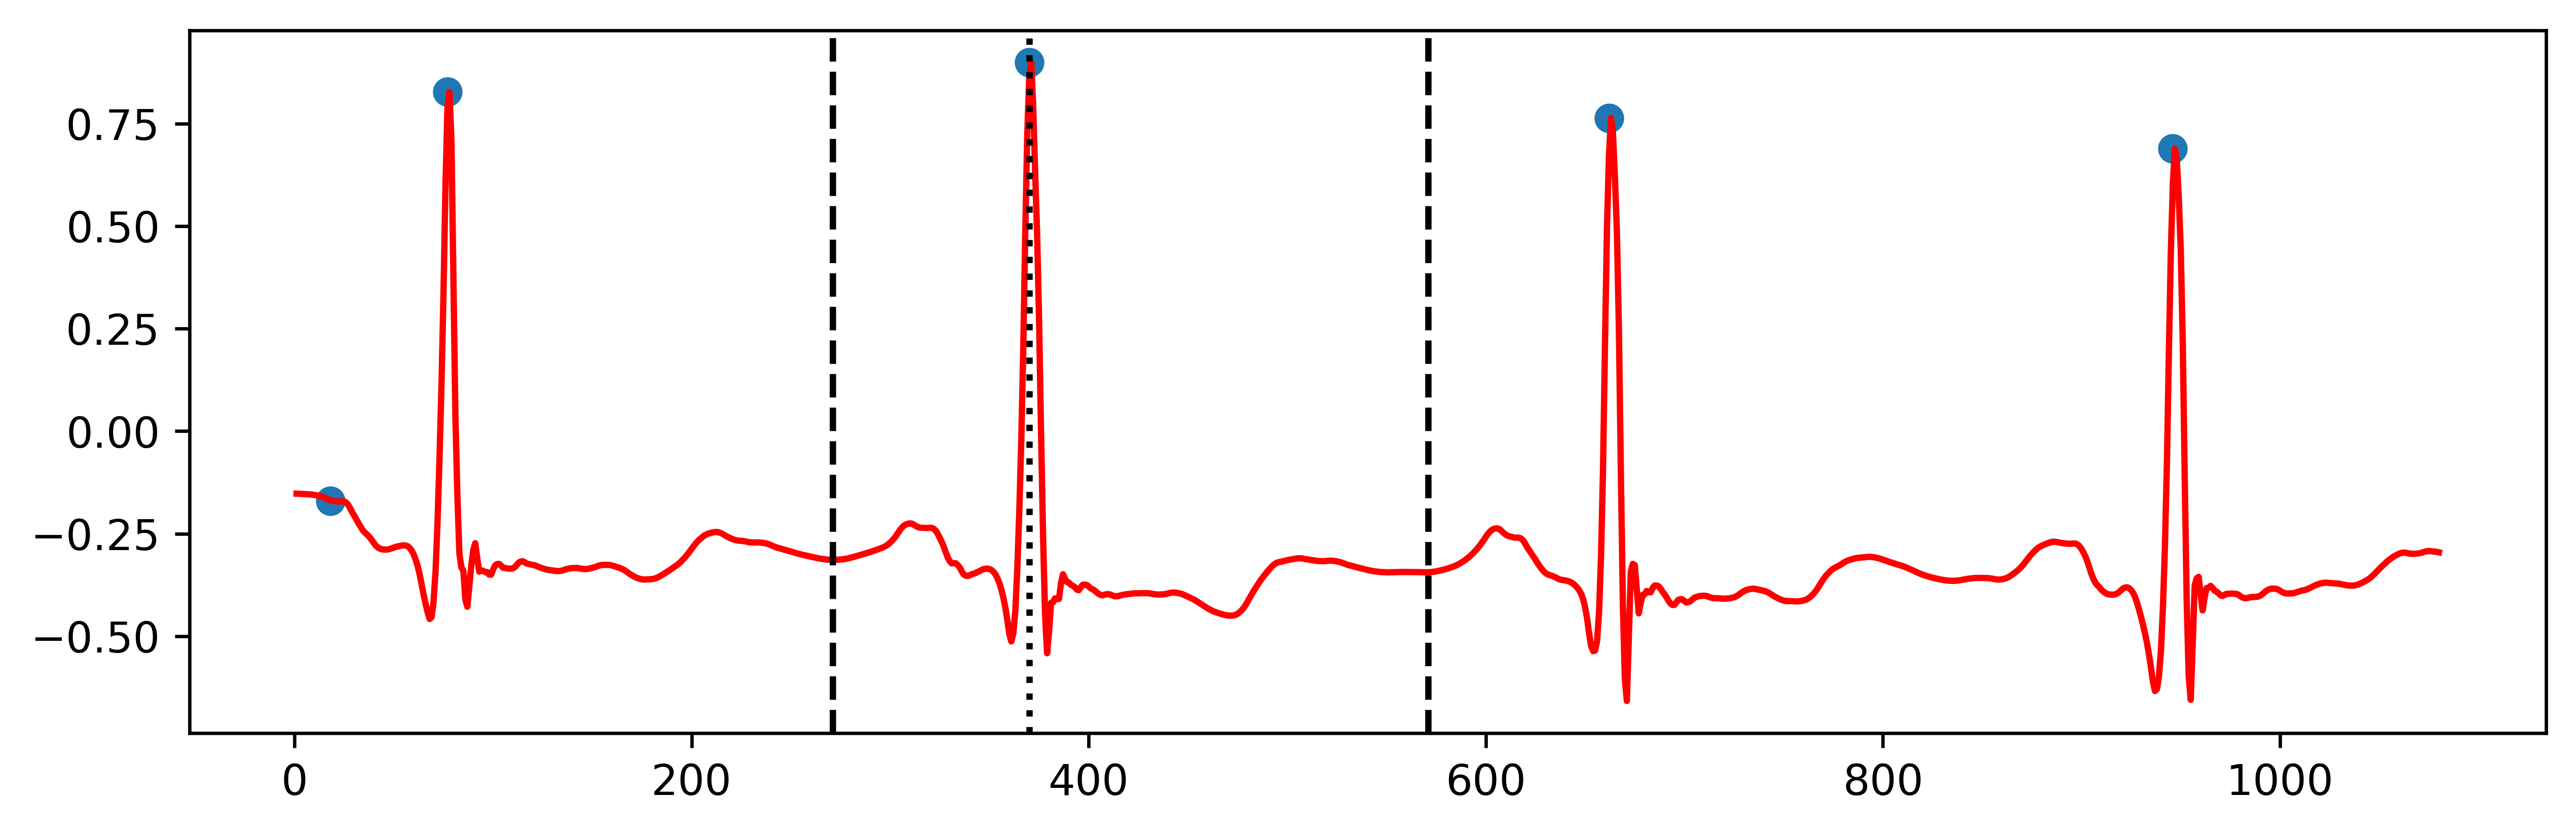

In [ ]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

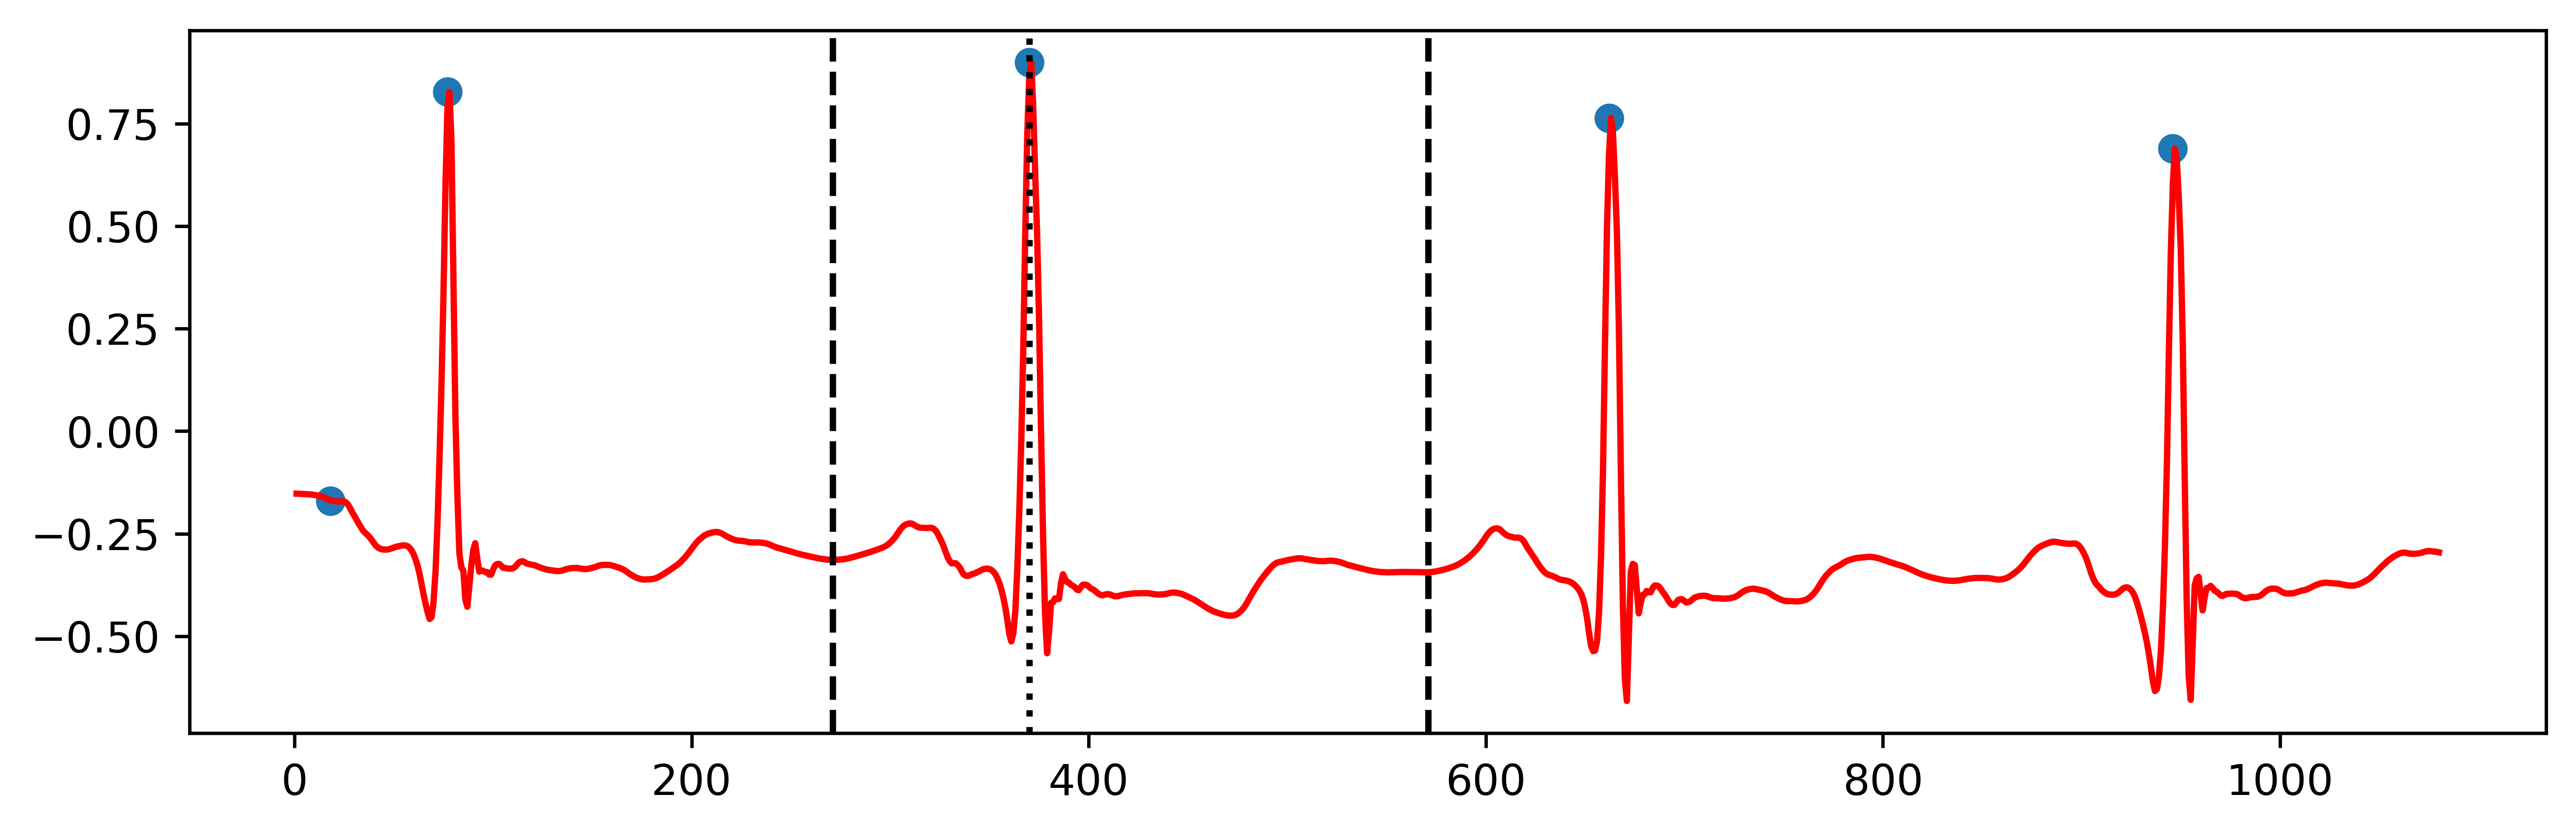

In [ ]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

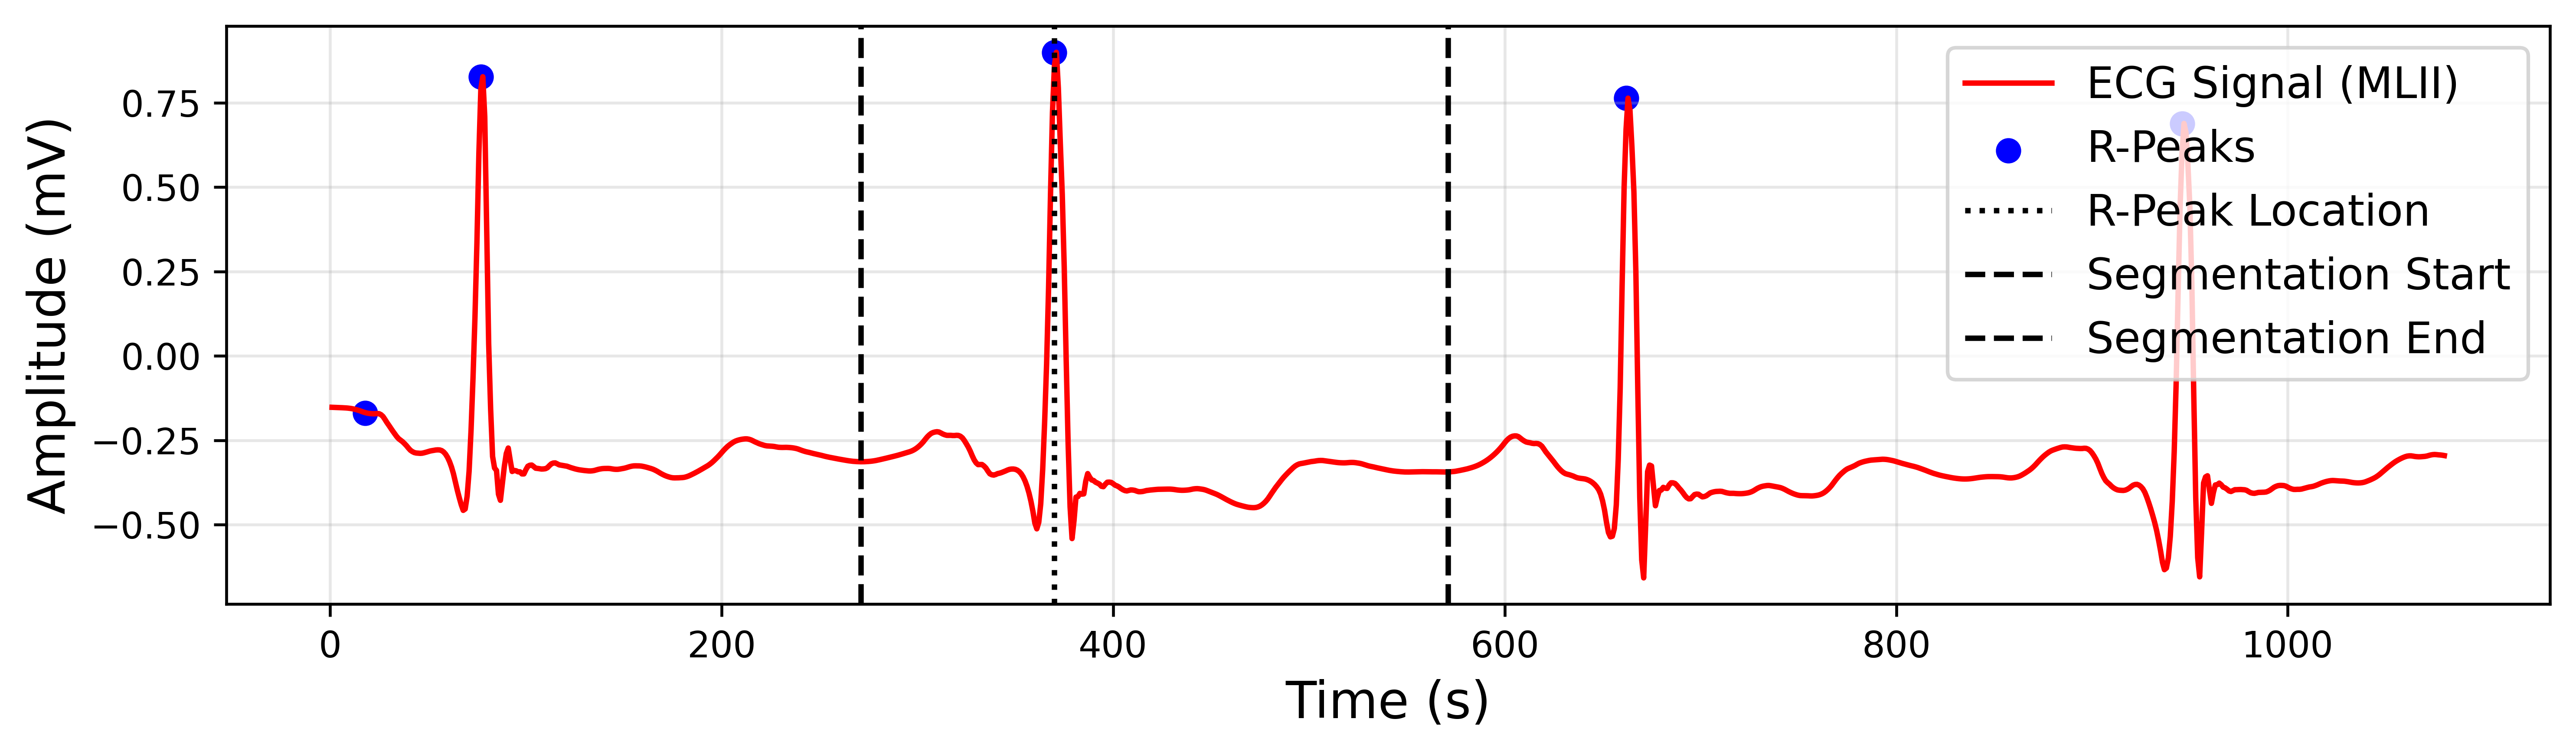

In [ ]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10, 3), dpi=600)
n_peak = 5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
    r_peak_x.append(Rlocation[i])
    r_peak_y.append(rdata[Rlocation[i]])

x = np.arange(1, 1081)
plt.plot(x, rdata[0:1080], color='red', label="ECG Signal (MLII)")  # Adding label for ECG signal
plt.scatter(r_peak_x, r_peak_y, color='blue', label="R-Peaks")  # Adding label for R-peaks

# Line plotting
plt.axvline(x=Rlocation[2], color='k', linestyle=':', label="R-Peak Location")
plt.axvline(x=Rlocation[2] - 99, color='k', linestyle='--', label="Segmentation Start")
plt.axvline(x=Rlocation[2] + 201, color='k', linestyle='--', label="Segmentation End")

# Add legend, x-axis and y-axis labels
plt.legend(loc='best', fontsize=12)  # Place the legend
plt.xlabel("Time (s)", fontsize=14)  # x-axis label
plt.ylabel("Amplitude (mV)", fontsize=14)  # y-axis label
plt.grid(True, alpha=0.3)  # Optional: Add grid for clarity
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot


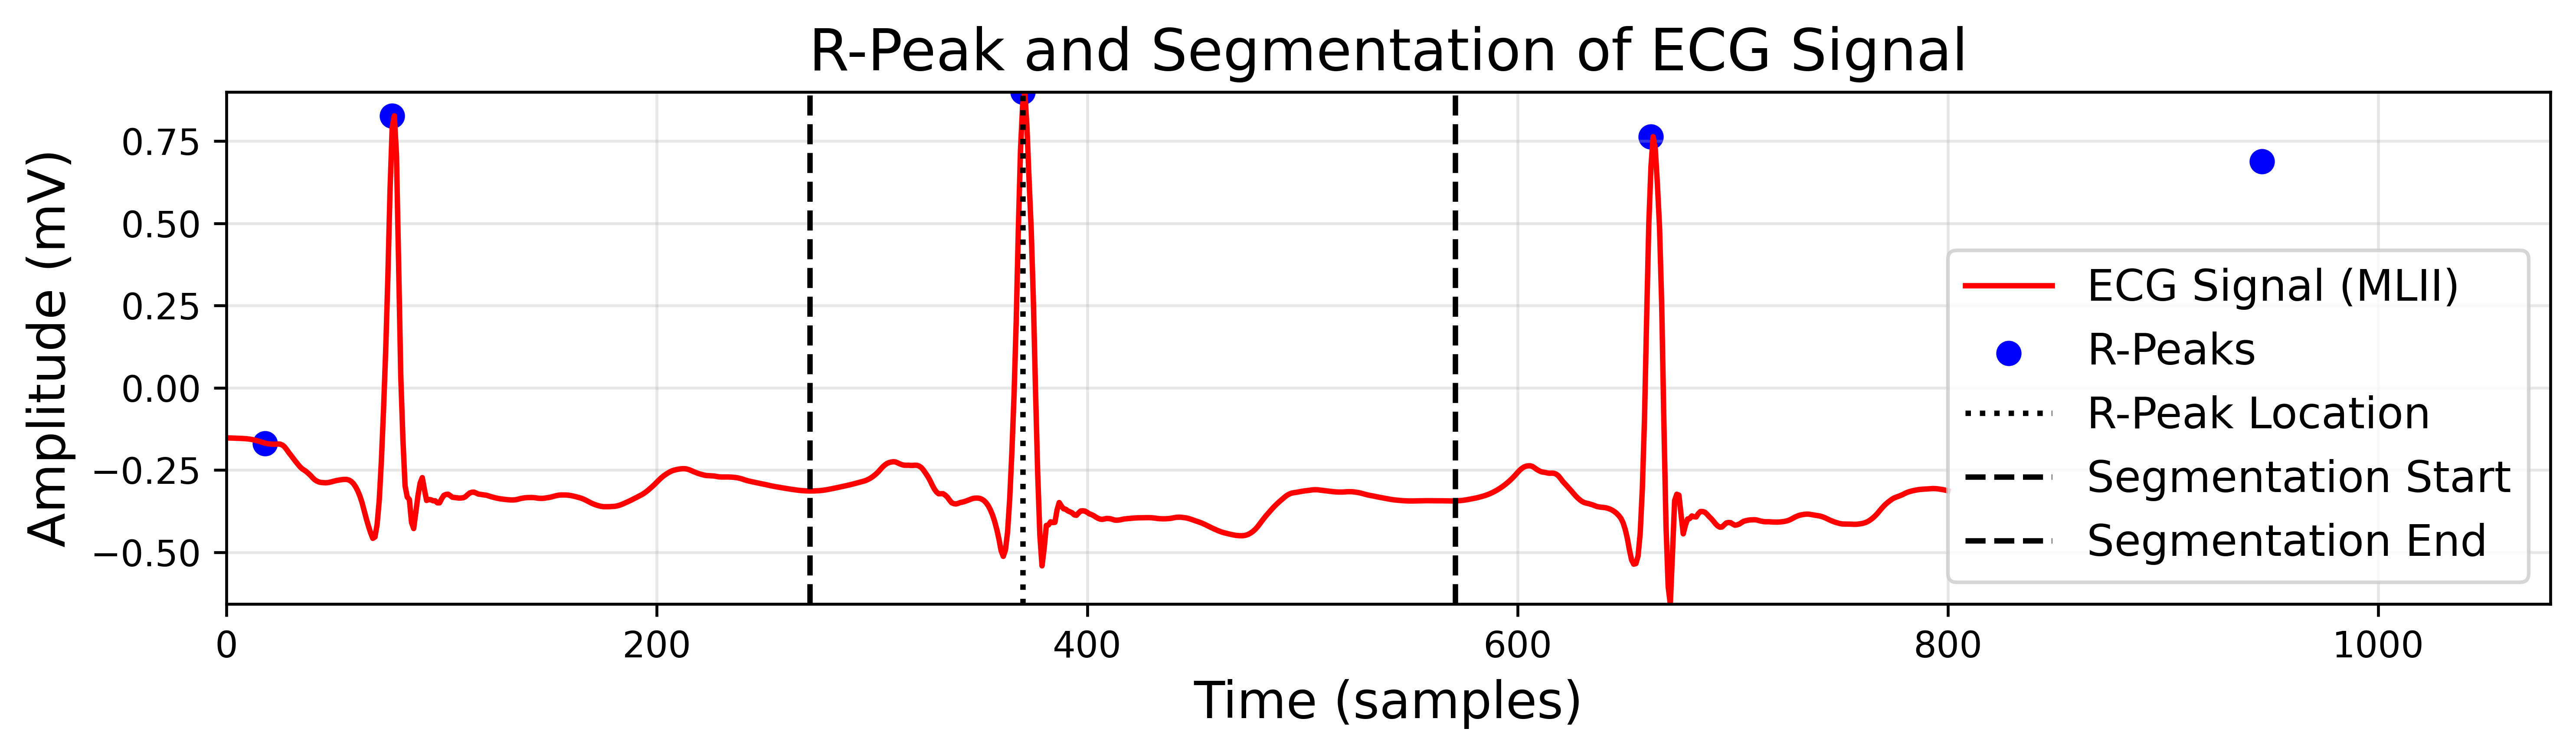

In [ ]:
# Plotting R-peaks and segmentation lines with no data beyond 800
fig = plt.figure(figsize=(10, 3), dpi=600)
n_peak = 5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
    r_peak_x.append(Rlocation[i])
    r_peak_y.append(rdata[Rlocation[i]])

x = np.arange(1, 1081)  # x-values for plotting

# Slice data up to 800 for plotting, leaving blank after that
plot_data = rdata[0:800]  # Limit data to the first 800 samples

# Plot ECG signal up to sample 800
plt.plot(x[:800], plot_data, color='red', label="ECG Signal (MLII)")  # Adding label for ECG signal
plt.scatter(r_peak_x, r_peak_y, color='blue', label="R-Peaks")  # Adding label for R-peaks

# Add the vertical lines for segmentation
plt.axvline(x=Rlocation[2], color='k', linestyle=':', label="R-Peak Location")
plt.axvline(x=Rlocation[2] - 99, color='k', linestyle='--', label="Segmentation Start")
plt.axvline(x=Rlocation[2] + 201, color='k', linestyle='--', label="Segmentation End")

# Add legend, x-axis and y-axis labels
plt.legend(loc='best', fontsize=12)  # Place the legend
plt.xlabel("Time (samples)", fontsize=14)  # x-axis label
plt.ylabel("Amplitude (mV)", fontsize=14)  # y-axis label
plt.title("R-Peak and Segmentation of ECG Signal", fontsize=16)  # Title
plt.grid(True, alpha=0.3)  # Optional: Add grid for clarity

# Display plot layout and show plot
plt.tight_layout()  # Adjust layout for better spacing
plt.xlim(0, 1080)  # Set the x-axis limit to 0-1080 to ensure the x-axis remains visible after 800
plt.ylim(min(rdata[:800]), max(rdata[:800]))  # Set y-axis limit to match the plotted portion
plt.show()  # Display the plot


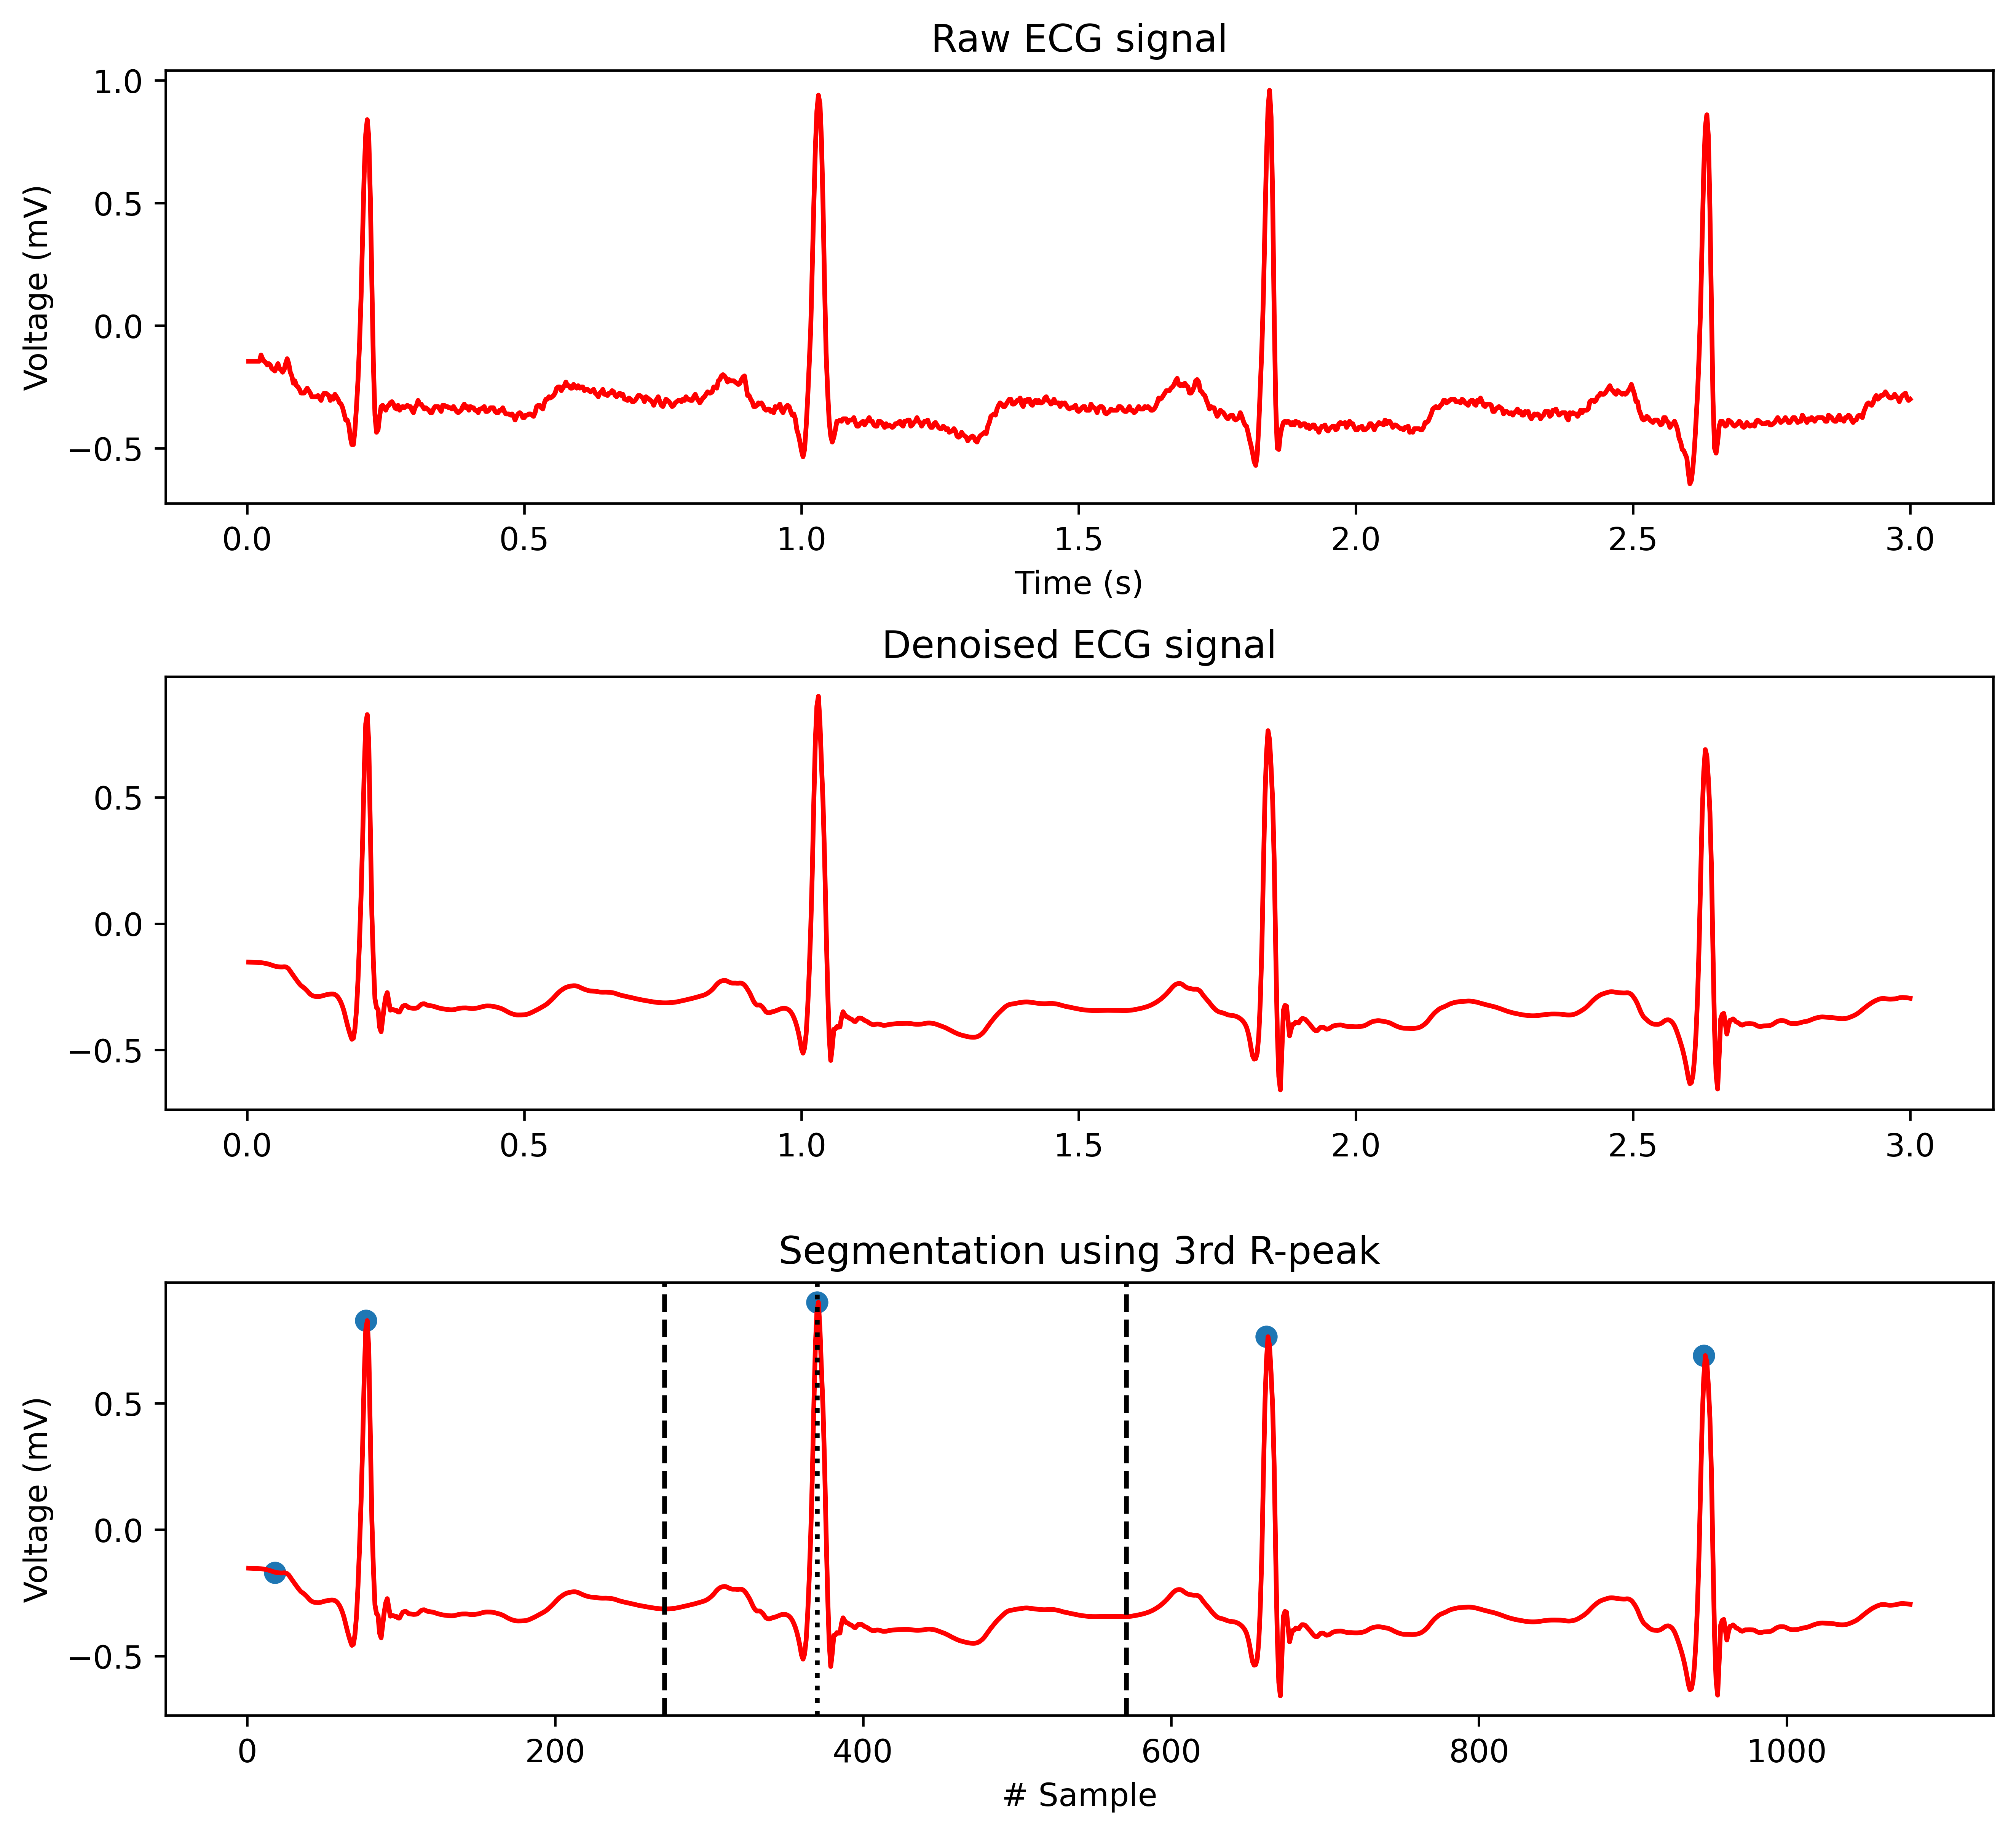

In [ ]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
# figure_path = r'\heartbeat_figures\\'
# fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

# **Part C: Dataset Loading**

In [ ]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [ ]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
from collections import Counter

In [ ]:
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         9.0: 7123,
         5.0: 2540,
         2.0: 7244,
         12.0: 7012,
         11.0: 802,
         1.0: 8063,
         13.0: 982,
         7.0: 83,
         14.0: 33,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         3.0: 16,
         8.0: 2})

In [ ]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [ ]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [ ]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']

  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)',
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)',
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)',
                  'Supraventricular prem. (S)', 'Premature ventr. (V)',
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)',
                  'Paced (/)', 'Fusion of pa. & no. (f)',
                  'Unclassifiable(Q)']

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)

  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

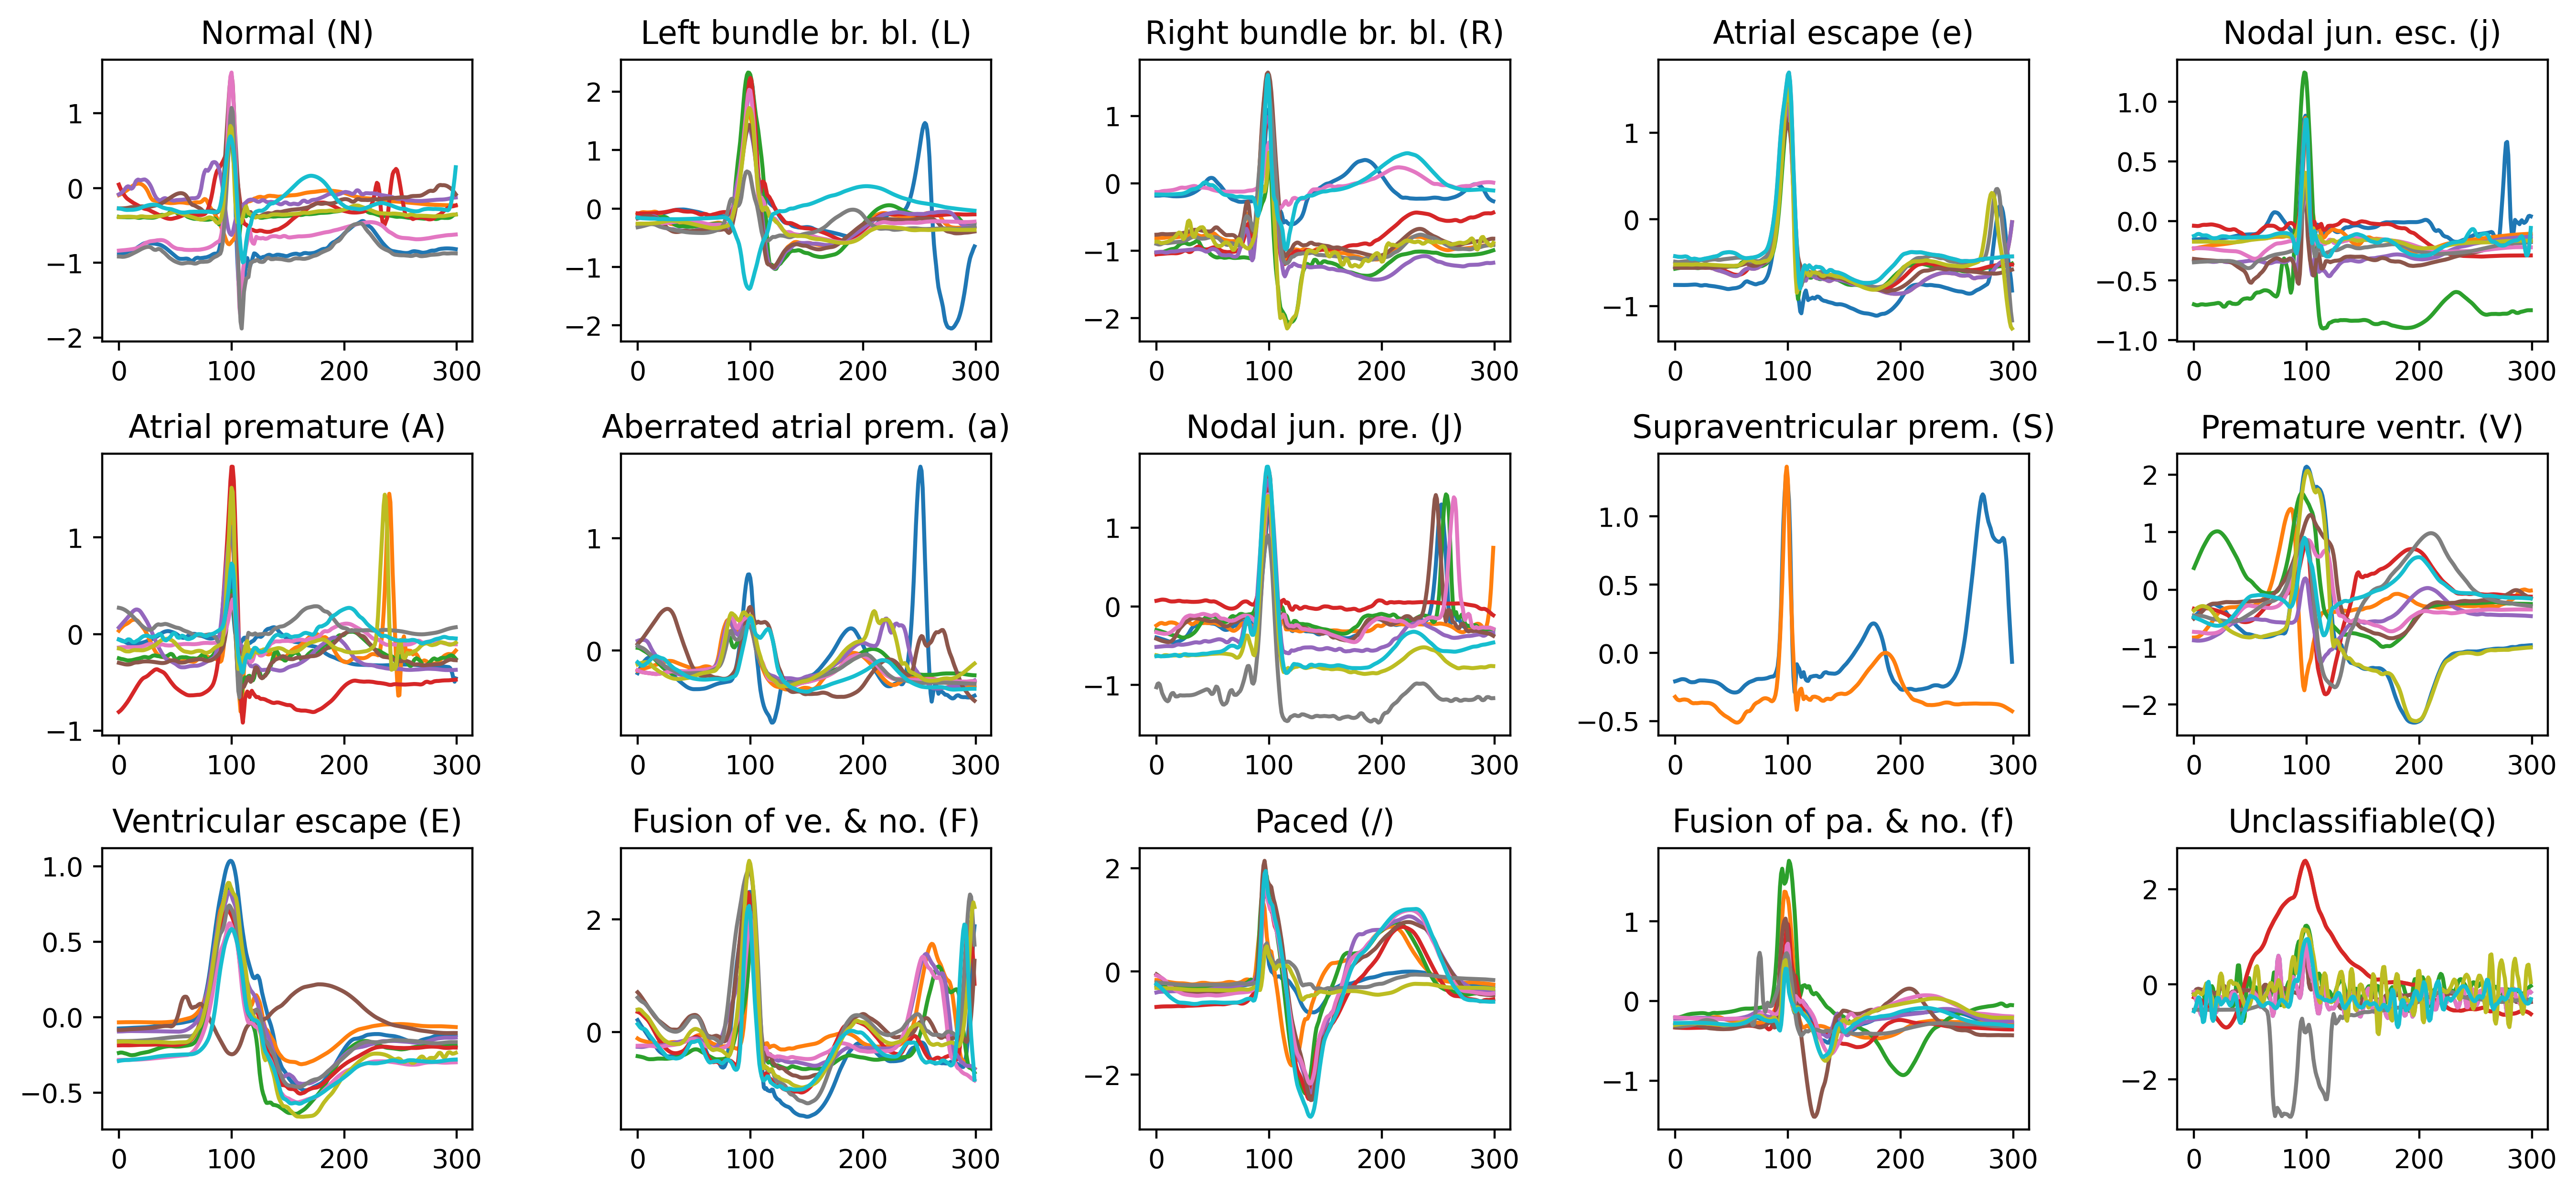

In [ ]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
# figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
# fig.savefig(figure_path+ 'all_heartbeats.png')

# **Part D: Train-Test Splitting and Class Balancing**

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [ ]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
Y = train_ds[:, 300]
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({2.0: 7244,
         0.0: 74920,
         13.0: 982,
         12.0: 7012,
         9.0: 7123,
         1.0: 8063,
         5.0: 2540,
         11.0: 802,
         6.0: 150,
         10.0: 106,
         4.0: 229,
         3.0: 16,
         7.0: 83,
         14.0: 33,
         8.0: 2})

In [ ]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [ ]:
# the original Y labels with 15 different classes are being converted into 5 broader classes and stored in Y_5class.
# This reduction simplifies the classification by grouping specific classes together based on certain characteristics,
# likely related to similarity in heartbeat types.

In [ ]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 1.0: 2775, 3.0: 802})

In [ ]:
ecg_dataset = np.copy(train_ds)

In [ ]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [ ]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [ ]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [ ]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

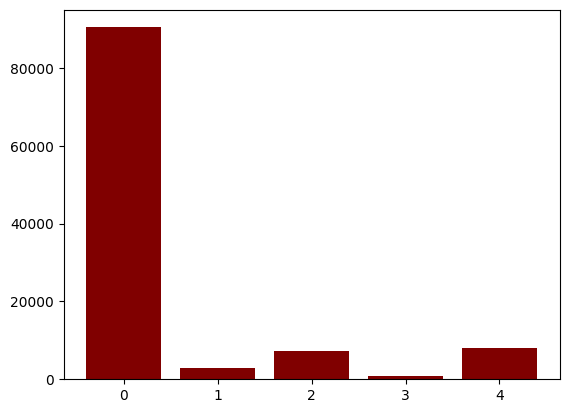

In [ ]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='300'>

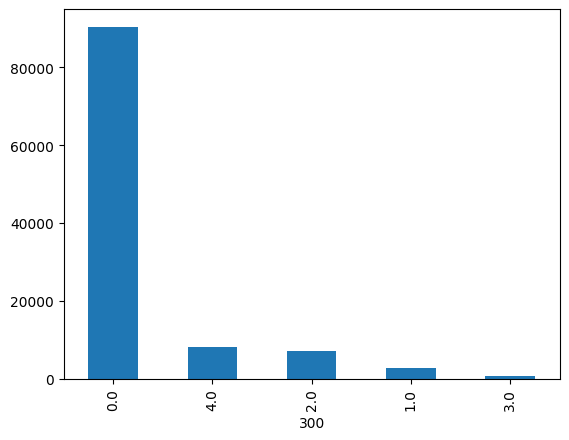

In [ ]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[300].value_counts().plot(kind='bar')

# **Part E: Train-Test Spliting**

In [ ]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [ ]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [ ]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [ ]:
# # saving the test data (in imbalanced condition)
# file_name = project_path + 'test_data.pkl'
# test_data.to_pickle(file_name)

300
0.0    72396
4.0     6421
2.0     5773
1.0     2223
3.0      631
Name: count, dtype: int64


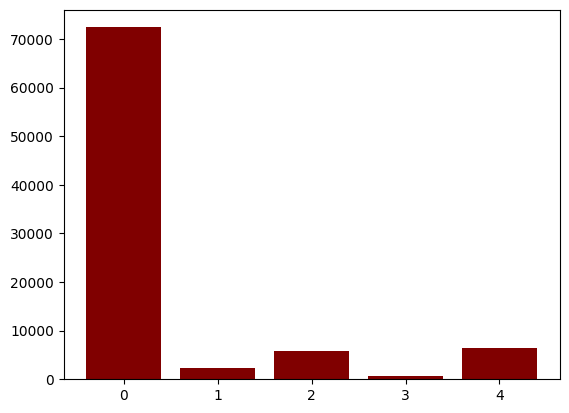

In [ ]:
# Imblanced training data graph ploting
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [ ]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [ ]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [ ]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [ ]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.28722445, -0.28848494, -0.28968116, ..., -0.2676001 ,
        -0.27120236,  0.        ],
       [-0.30751179, -0.3057489 , -0.30397116, ...,  0.75158413,
         0.82591842,  0.        ],
       [-0.16800687, -0.17244045, -0.17732933, ..., -0.28988055,
        -0.28821461,  1.        ],
       ...,
       [-0.07768788, -0.0759095 , -0.07457754, ..., -0.13804258,
        -0.13573806,  0.        ],
       [-0.65170895, -0.66662218, -0.68198135, ..., -0.11181153,
        -0.0988044 ,  2.        ],
       [ 0.0824179 ,  0.05861659,  0.0314233 , ...,  1.74909868,
         1.61083942,  2.        ]])

300
0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64


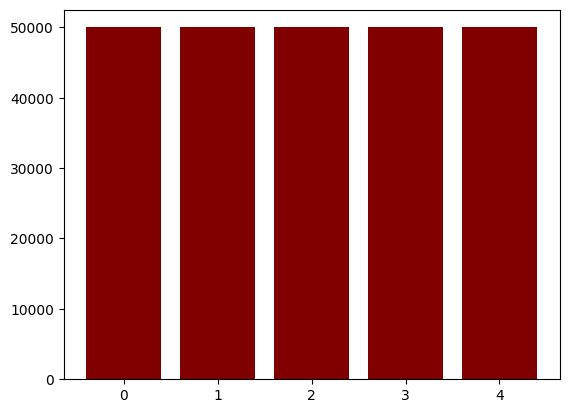

In [ ]:
# blanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
# file_name = project_path + 'train_data_SMOTE.pkl'
# train_data_r.to_pickle(file_name)

In [ ]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

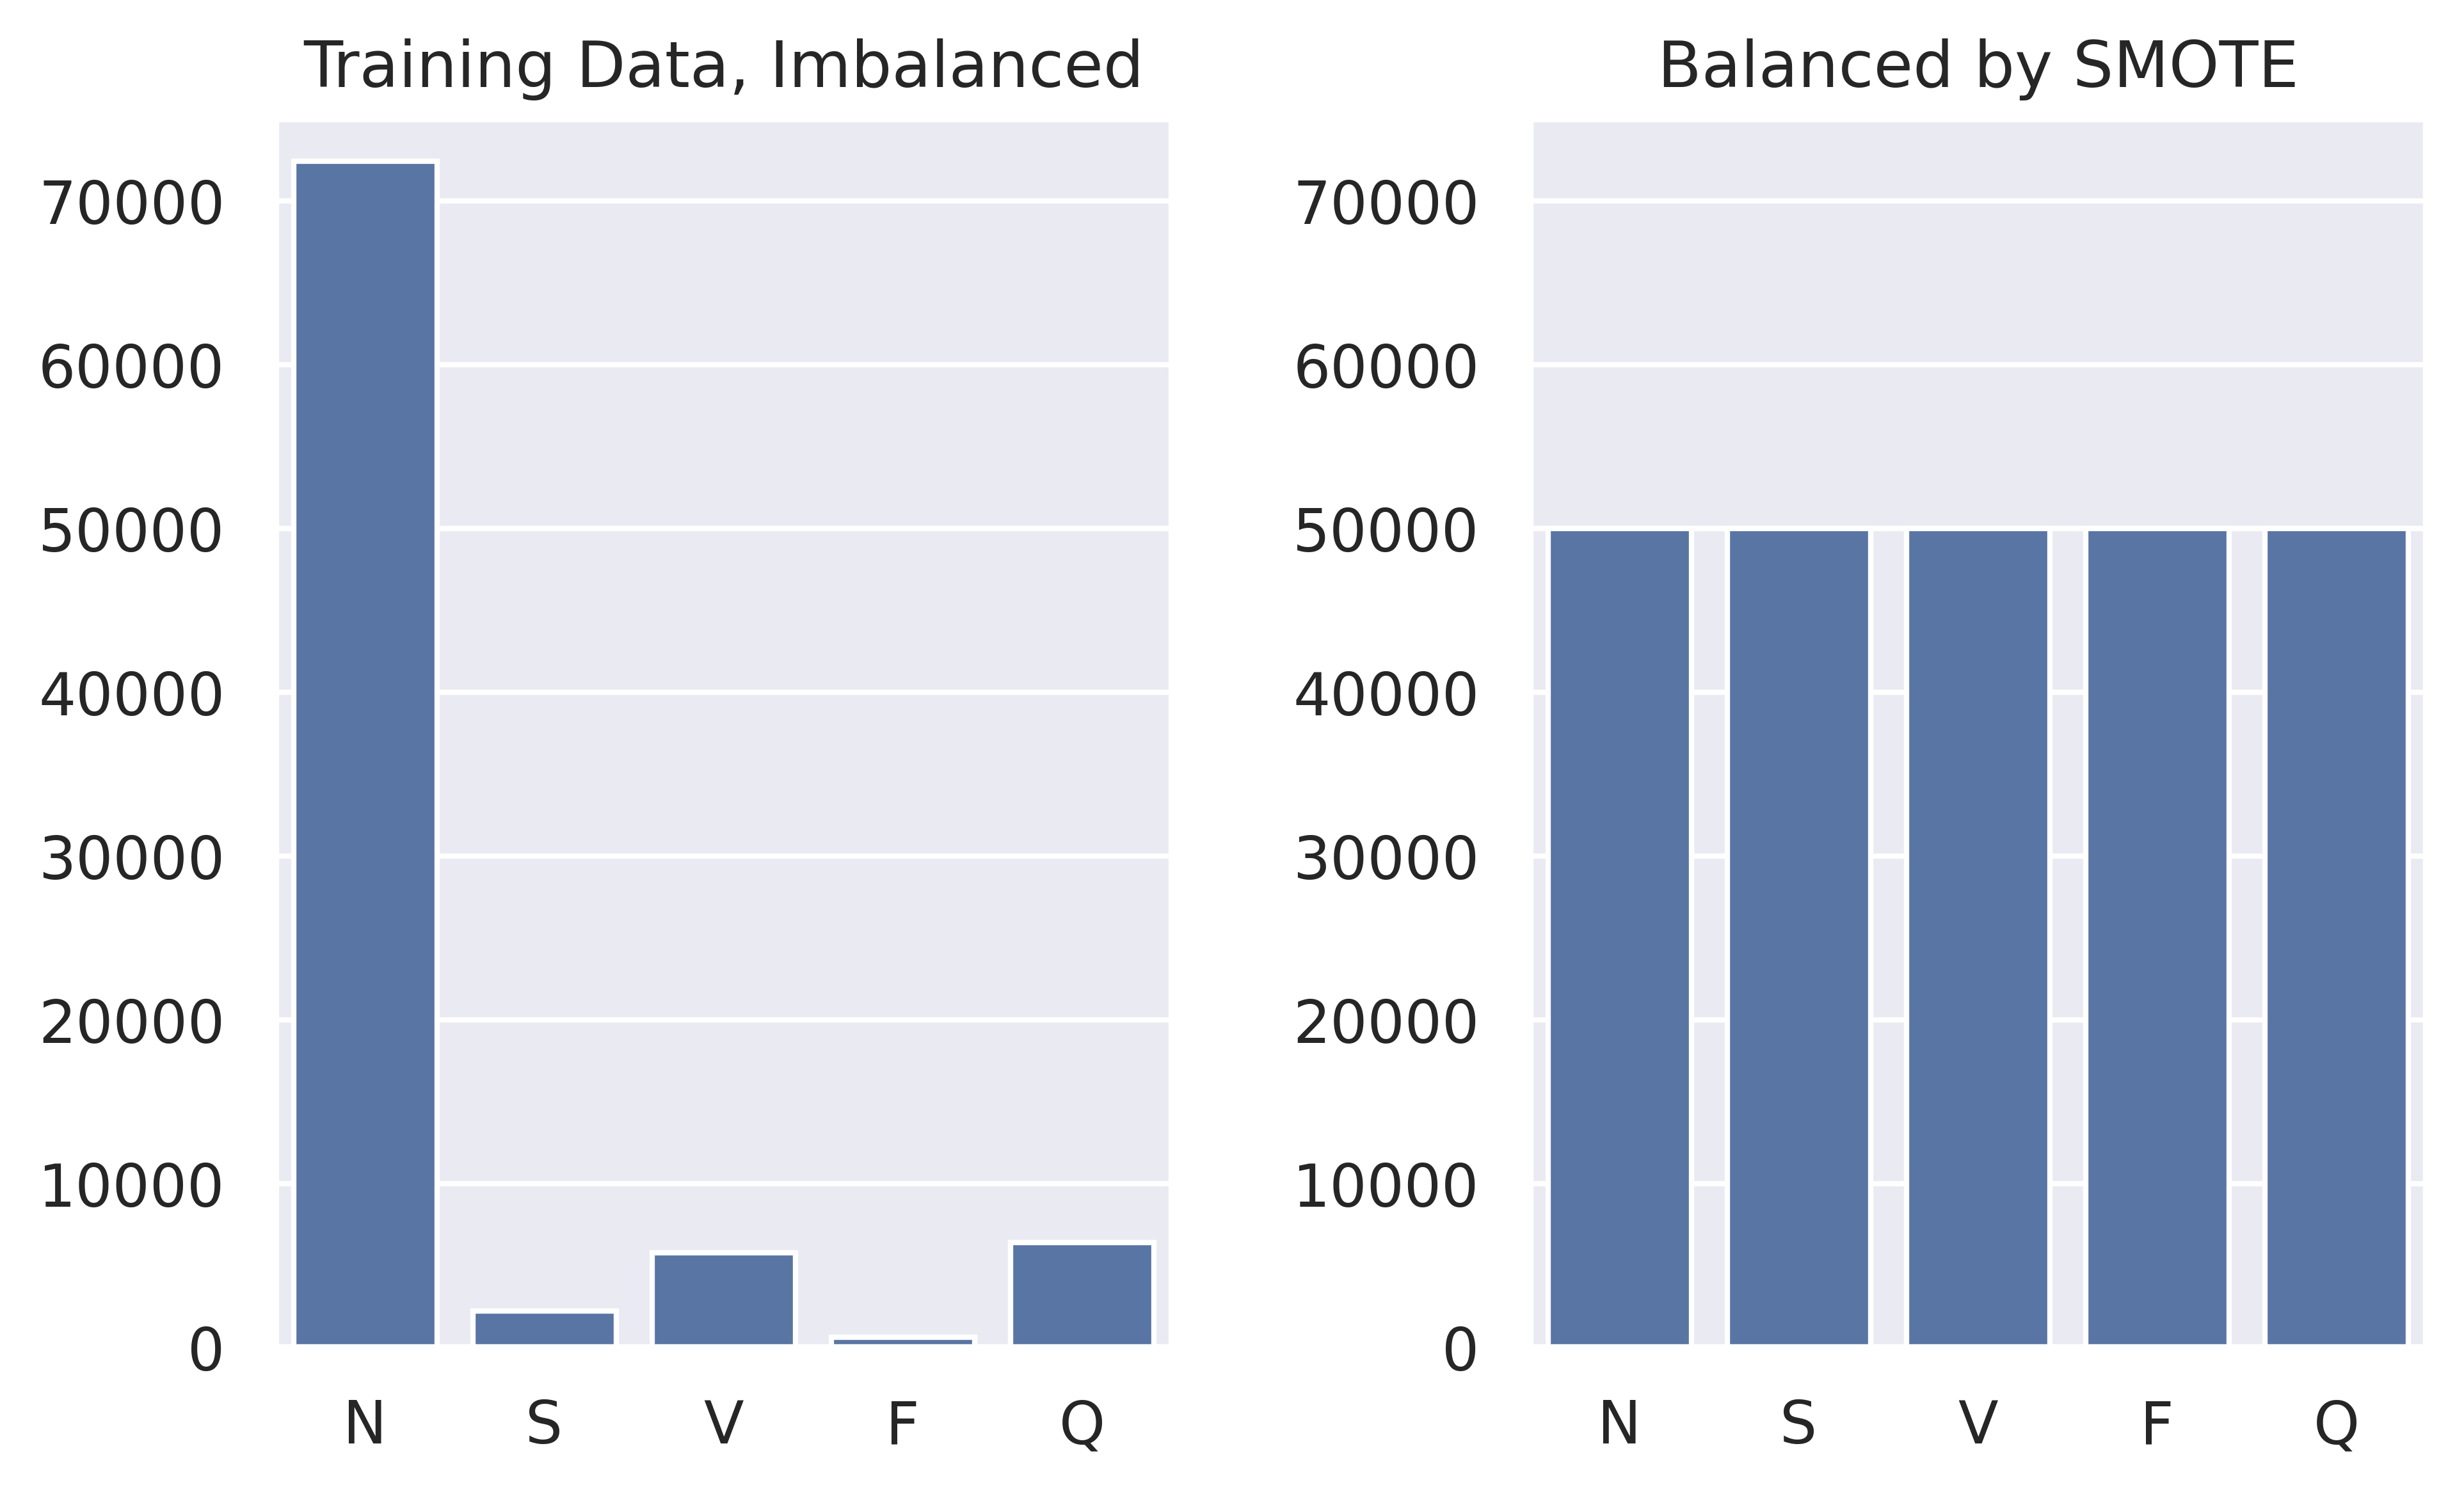

In [ ]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

# figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
# fig.savefig(figure_path+ 'Class balancing.png')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87444, 300)
(87444, 1)
(21861, 300)
(21861, 1)


In [ ]:
import os

# Define the directory path inside Google Drive
save_path = "/content/drive/My Drive/arrhy_split_data/"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

print("Directory created successfully!")
import numpy as np

# Define your save path inside Google Drive
save_path = "/content/drive/My Drive/arrhy_split_data/"  # Change folder name if needed

# Save arrays as .npy files
np.save(save_path + "x_train.npy", x_train)
np.save(save_path + "y_train.npy", y_train)
np.save(save_path + "x_test.npy", x_test)
np.save(save_path + "y_test.npy", y_test)

print("Files saved successfully in Google Drive!")


Directory created successfully!
Files saved successfully in Google Drive!


In [ ]:
# Load the Saved Files Later UNCOMMENT BELOW:
# x_train = np.load("/content/drive/My Drive/colab_data/x_train.npy")
# y_train = np.load("/content/drive/My Drive/colab_data/y_train.npy")
# x_test = np.load("/content/drive/My Drive/colab_data/x_test.npy")
# y_test = np.load("/content/drive/My Drive/colab_data/y_test.npy")

# print("Data loaded successfully!")

# **Part F: CAT-NET Model Building and Training**

In [ ]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [ ]:
import os

# Define the directory path inside Google Drive
save_path = "/content/drive/My Drive/cat_model/"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

print("Directory created successfully!")

Directory created successfully!


In [ ]:
project_path="/content/drive/MyDrive/cat_model/"
project_path

'/content/drive/MyDrive/cat_model/'

In [ ]:
#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = "/content/drive/My Drive/cat_model/" + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = "/content/drive/My Drive/cat_model/" + "ecg_model_code 17_t5.h5"

In [ ]:
# percentage of training data used for model validation
ratio = 0.2

In [ ]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath=project_path + "code_17_t5_weights.weights.h5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=20,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 300, 16)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 150, 32)             │          11,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 75, 64)              │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 38, 64)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 38, 128)             │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 38, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 38, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         311,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 777,797 (2.97 MB)

 Trainable params: 777,797 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 504s 912ms/step - accuracy: 0.8944 - loss: 0.3857 - val_accuracy: 0.9744 - val_loss: 0.1000
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 405s 741ms/step - accuracy: 0.9746 - loss: 0.0954 - val_accuracy: 0.9814 - val_loss: 0.0701
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 373s 614ms/step - accuracy: 0.9804 - loss: 0.0729 - val_accuracy: 0.9826 - val_loss: 0.0638
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 468s 855ms/step - accuracy: 0.9845 - loss: 0.0557 - val_accuracy: 0.9859 - val_loss: 0.0564
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 388s 647ms/step - accuracy: 0.9866 - loss: 0.0488 - val_accuracy: 0.9862 - val_loss: 0.0552
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 357s 600ms/step - accuracy: 0.9880 - loss: 0.0431 - val_accuracy: 0.9862 - val_loss: 0.0525
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 389s 613ms/step - accuracy: 0.9895 - loss: 0.0348 - val_accuracy: 0.9870 - val_loss: 0.0435
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 380s 610ms/step - accuracy: 0.9907 -

In [ ]:
# Lists to store training accuracy and loss
training_accuracy_7 = history.history['accuracy']
training_loss_7 = history.history['loss']


# Print or inspect the saved values
print("Training Accuracy per Epoch:", training_accuracy_7)
print("Training Loss per Epoch:", training_loss_7)


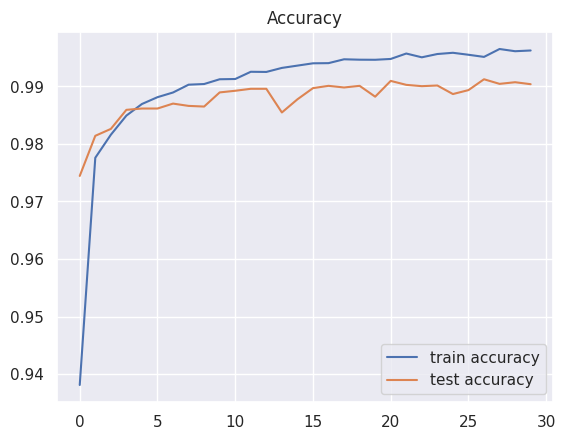

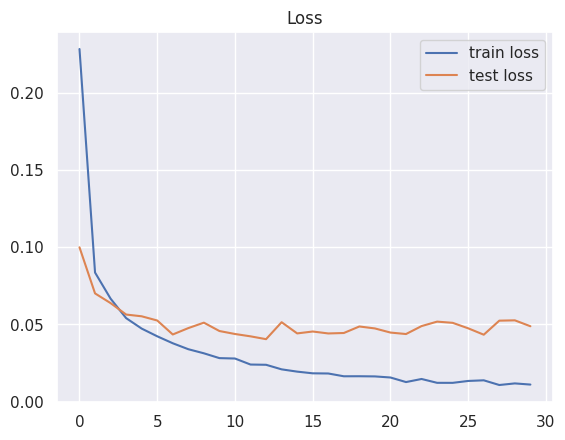

In [ ]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.62, Test Accuracy: 99.07
Training Loss: 1.52, Test Loss: 4.60


In [ ]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

Training Accuracy: 99.58, Test Accuracy: 99.09
Training Loss: 1.55, Test Loss: 4.27


In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

684/684 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step


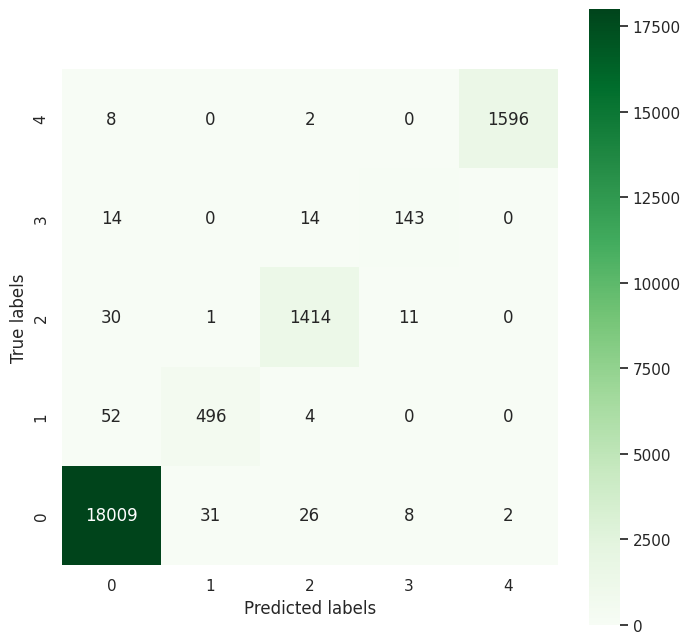

In [ ]:
# predict
Y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test, Y_pred)

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

In [ ]:
# a. Recently Trained Model
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step


N          S          V          F          Q
Sensitivity (%)         99.629343  89.855072  97.115385  83.625731  99.377335
Specificity (%)         97.252312  99.849829  99.774565  99.912402  99.990126
F1 Score (%)            99.527481  91.851852  96.982167  85.885886  99.625468
Per Class Accuracy (%)  99.217785  99.597457  99.597457  99.785005  99.945108

In [ ]:
# b. Best Model
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model2.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step


N          S          V          F          Q
Sensitivity (%)         99.607214  90.760870  96.978022  83.625731  99.750934
Specificity (%)         97.516513  99.779436  99.862779  99.903181  99.960504
F1 Score (%)            99.543884  91.090909  97.513812  85.373134  99.626866
Per Class Accuracy (%)  99.245231  99.551713  99.670646  99.775857  99.945108

# **Part G: LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
x_train = train_data_0_resampled[:, :-1]  # Features from resampled data
y_train = train_data_0_resampled[:, -1]   # Labels from resampled data
x_train_oversampled = train_data_1234_resampled[:, :-1]
y_train_oversampled = train_data_1234_resampled[:, -1]

In [ ]:
x_train_balanced = np.vstack((x_train, x_train_oversampled))
y_train_balanced = np.hstack((y_train, y_train_oversampled))

In [ ]:
x_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 1: Loss = 0.6448, Accuracy = 0.7949
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 2: Loss = 0.6155, Accuracy = 0.7993
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 3: Loss = 0.6018, Accuracy = 0.8018
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 4: Loss = 0.5935, Accuracy = 0.8038
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 5: Loss = 0.5877, Accuracy = 0.8049
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 6: Loss = 0.5835, Accuracy = 0.8061
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 7: Loss = 0.5801, Accuracy = 0.8074
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 8: Loss = 0.5774, Accuracy = 0.8083
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 9: Loss = 0.5752, Accuracy = 0.8090
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 10: Loss = 0.5733, Accuracy = 0.8096
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 11: Loss = 0.5716, Accuracy = 0.8100
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 12: Loss = 0.5702, Accuracy = 0.8104
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 13: Loss = 0.5690, Accuracy = 0.8107
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 14: Loss = 0.5678, Accuracy = 0.8110
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 15: Loss = 0.5668, Accuracy = 0.8112
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 16: Loss = 0.5659, Accuracy = 0.8114
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 17: Loss = 0.5650, Accuracy = 0.8117
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 18: Loss = 0.5643, Accuracy = 0.8119
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 19: Loss = 0.5635, Accuracy = 0.8122
helo


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


helo
Epoch 20: Loss = 0.5629, Accuracy = 0.8124


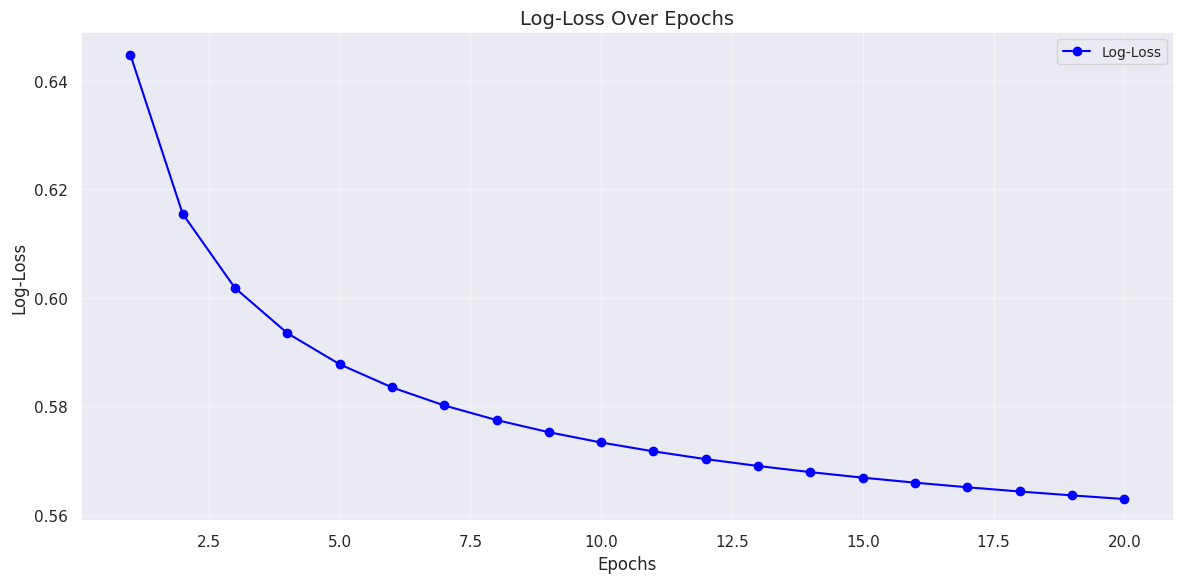

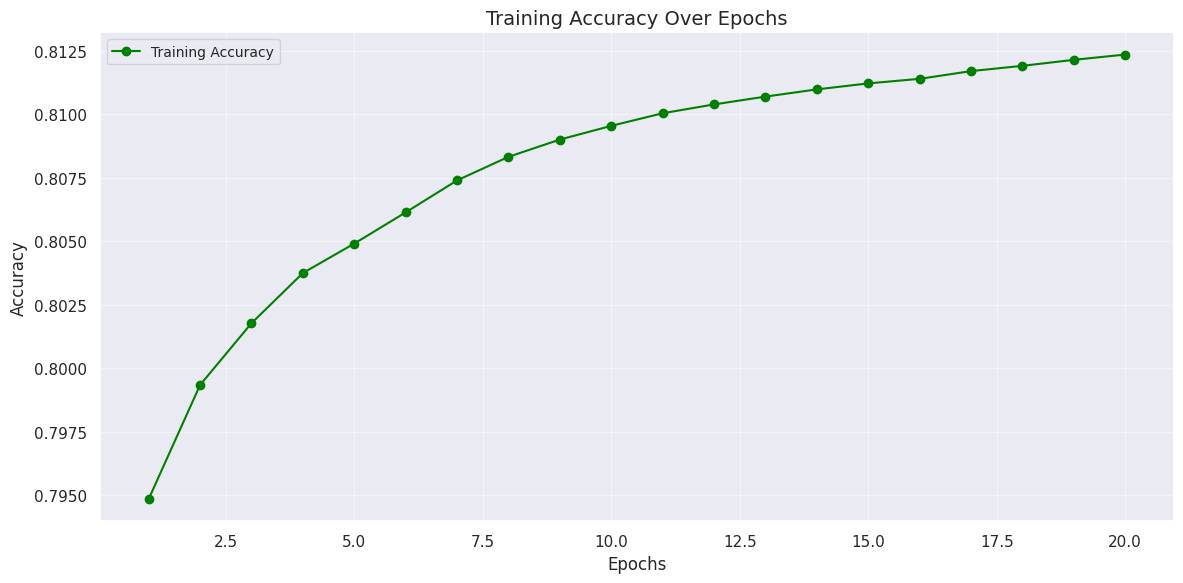

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# Logistic Regression with warm_start and saga solver
log_reg_model = LogisticRegression(max_iter=1, warm_start=True, random_state=42, solver='saga')

# Number of epochs (iterations)
epochs = 20

# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Training process
for epoch in range(epochs):
    print("helo")
    log_reg_model.fit(x_train_balanced, y_train_balanced)  # Train for 1 iteration
    y_train_pred_proba = log_reg_model.predict_proba(x_train_balanced)  # Get predicted probabilities
    y_train_pred = log_reg_model.predict(x_train_balanced)  # Get predicted labels
    print("helo")
    # Calculate log-loss and accuracy
    loss = log_loss(y_train_balanced, y_train_pred_proba)
    accuracy = accuracy_score(y_train_balanced, y_train_pred)

    # Store metrics
    train_losses.append(loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

# Plot Log-Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Log-Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Log-Loss', fontsize=12)
plt.title('Log-Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
y_pred = log_reg_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

Logistic Regression Accuracy: 69.67%


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Predictions
y_pred = log_reg_model.predict(x_test)
y_pred_proba = log_reg_model.predict_proba(x_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

# For multiclass problems, use an averaging strategy for recall and F1-score
sensitivity = recall_score(y_test, y_pred, average='macro')  # Sensitivity averaged across classes
cm = confusion_matrix(y_test, y_pred)
tn_fp_sum = cm.sum(axis=0) - cm.diagonal()  # Sum of false positives and true negatives per class
specificity = (cm.diagonal() / (cm.diagonal() + tn_fp_sum)).mean()  # Average specificity
f1 = f1_score(y_test, y_pred, average='macro')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

# Display metrics
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")


Logistic Regression Accuracy: 69.67%
Sensitivity (Recall): 0.80
Specificity: 0.47
F1-Score: 0.51
AUC-ROC Score: 0.93


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.67      0.79     18076
         1.0       0.13      0.78      0.22       552
         2.0       0.34      0.79      0.48      1456
         3.0       0.15      0.86      0.25       171
         4.0       0.77      0.89      0.82      1606

    accuracy                           0.70     21861
   macro avg       0.47      0.80      0.51     21861
weighted avg       0.89      0.70      0.76     21861



In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[12076  2720  2146   777   357]
 [   80   429    17     6    20]
 [  119    72  1154    63    48]
 [    8     2    14   147     0]
 [   71    50    54     7  1424]]


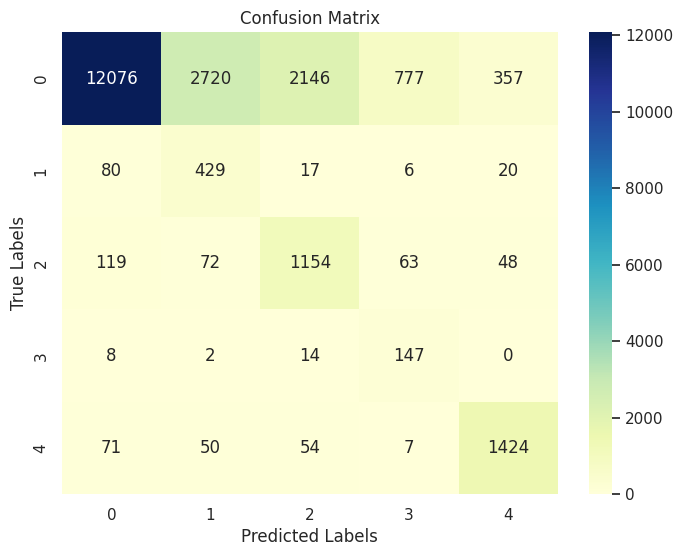

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(train_losses)
print(train_accuracies)

[0.6448225774919056, 0.615465379627161, 0.601781693149366, 0.5934587729864192, 0.587718013334179, 0.5834505189209215, 0.5801176531749757, 0.5774217846901049, 0.5751829330976754, 0.5732848118733722, 0.5716483990883315, 0.57021783787202, 0.5689523937048364, 0.5678216069287902, 0.5668022300637559, 0.5658762129450406, 0.5650293318184286, 0.5642502307445394, 0.5635297362334771, 0.5628603580397988]
[0.794856, 0.799348, 0.80178, 0.803756, 0.804916, 0.806144, 0.807404, 0.808332, 0.809012, 0.809552, 0.810048, 0.810396, 0.810704, 0.810988, 0.811224, 0.811404, 0.811708, 0.811916, 0.812152, 0.81236]


# **Part H: GRU**

In [ ]:
!pip install neurokit2
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 10.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87444, 300)
(87444, 1)
(21861, 300)
(21861, 1)


In [ ]:
x_train_2 = np.load("/content/drive/My Drive/arrhy_split_data/x_train.npy")
y_train_2 = np.load("/content/drive/My Drive/arrhy_split_data/y_train.npy")
x_test_2 = np.load("/content/drive/My Drive/arrhy_split_data/x_test.npy")
y_test_2 = np.load("/content/drive/My Drive/arrhy_split_data/y_test.npy")

print("Data loaded successfully!")

Data loaded successfully!


In [ ]:
x_train = x_train.astype(np.float32)
x_train_oversampled = x_train_oversampled.astype(np.float32)
x_train_balanced = np.vstack((x_train, x_train_oversampled))

In [ ]:
x_train_balanced = np.vstack((x_train, x_train_oversampled))
y_train_balanced = np.hstack((y_train, y_train_oversampled))

In [ ]:
x_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

In [ ]:
scaler = StandardScaler()
x_train_balanced = scaler.fit_transform(x_train_balanced)
x_test = scaler.transform(x_test)

In [ ]:
x_train_balanced = x_train_balanced.reshape(x_train_balanced.shape[0], 1, x_train_balanced.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the encoder with sparse_output
encoder = OneHotEncoder(sparse_output=False)

# Transform the data
y_train_balanced = encoder.fit_transform(y_train_balanced.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))


In [ ]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(x_train_balanced.shape[1], x_train_balanced.shape[2]), return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes for arrhythmias
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
Epoch 1: Loss = 0.1514, Accuracy = 0.9481
Epoch 2/20
Epoch 2: Loss = 0.0731, Accuracy = 0.9751
Epoch 3/20
Epoch 3: Loss = 0.0586, Accuracy = 0.9800
Epoch 4/20
Epoch 4: Loss = 0.0504, Accuracy = 0.9826
Epoch 5/20
Epoch 5: Loss = 0.0446, Accuracy = 0.9847
Epoch 6/20
Epoch 6: Loss = 0.0401, Accuracy = 0.9866
Epoch 7/20
Epoch 7: Loss = 0.0375, Accuracy = 0.9873
Epoch 8/20
Epoch 8: Loss = 0.0369, Accuracy = 0.9876
Epoch 9/20
Epoch 9: Loss = 0.0330, Accuracy = 0.9887
Epoch 10/20
Epoch 10: Loss = 0.0312, Accuracy = 0.9894
Epoch 11/20
Epoch 11: Loss = 0.0309, Accuracy = 0.9897
Epoch 12/20
Epoch 12: Loss = 0.0289, Accuracy = 0.9902
Epoch 13/20
Epoch 13: Loss = 0.0271, Accuracy = 0.9910
Epoch 14/20
Epoch 14: Loss = 0.0273, Accuracy = 0.9908
Epoch 15/20
Epoch 15: Loss = 0.0265, Accuracy = 0.9911
Epoch 16/20
Epoch 16: Loss = 0.0262, Accuracy = 0.9912
Epoch 17/20
Epoch 17: Loss = 0.0261, Accuracy = 0.9913
Epoch 18/20
Epoch 18: Loss = 0.0243, Accuracy = 0.9918
Epoch 19/20
Epoch 19: Loss =

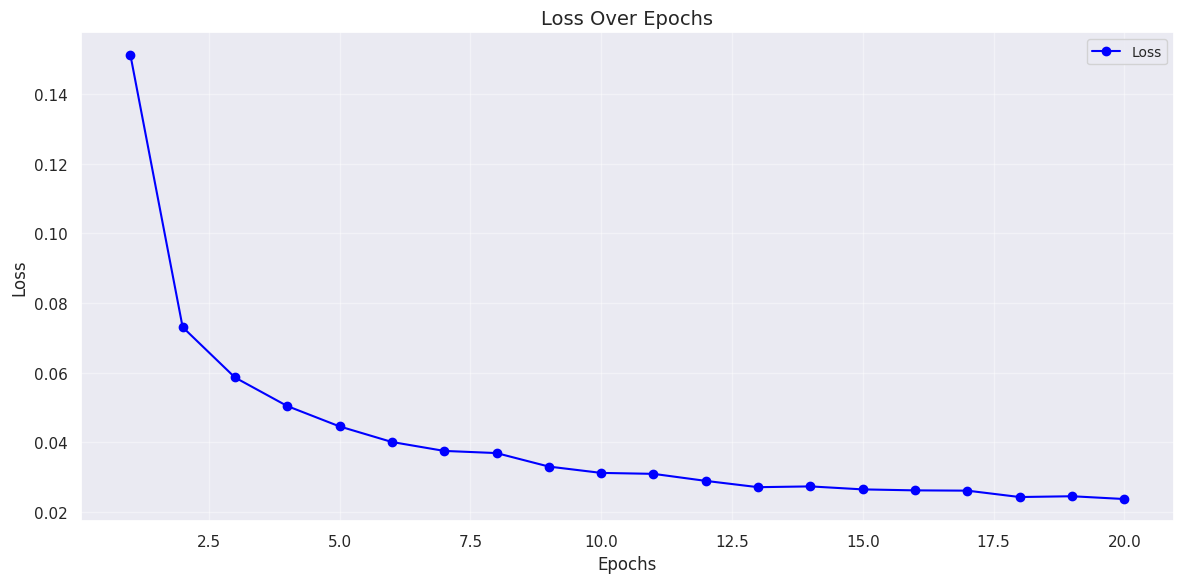

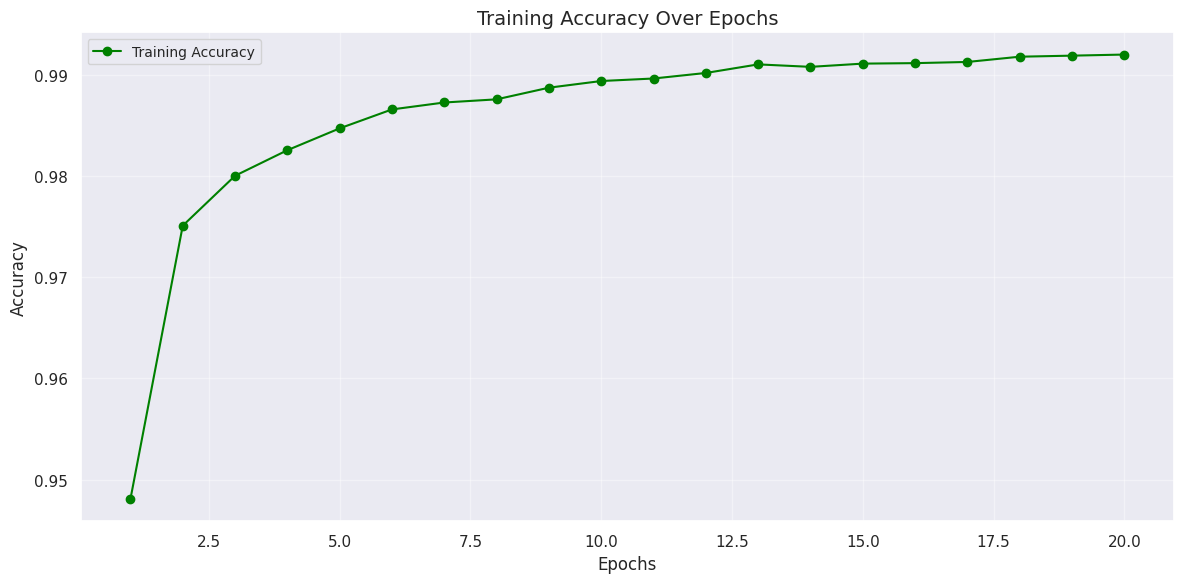

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Define the GRU model (you should already have the model defined, so no need to redefine it here)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(x_train_balanced.shape[1], x_train_balanced.shape[2]), return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes for arrhythmias
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Number of epochs
epochs = 20

# Initialize lists to store metrics
train_losses_2 = []
train_accuracies_2 = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train for one epoch
    history = gru_model.fit(x_train_balanced, y_train_balanced, epochs=1, batch_size=32, verbose=0, validation_data=(x_test, y_test_encoded))

    # Get the loss and accuracy for the epoch
    train_loss = history.history['loss'][0]
    train_accuracy = history.history['accuracy'][0]

    # Store metrics
    train_losses_2.append(train_loss)
    train_accuracies_2.append(train_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Plot Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses_2, label='Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies_2, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

# Predictions from the GRU model
y_pred_probs = gru_model.predict(x_test)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred, average='macro')  # Macro-average for all classes

# Calculate Specificity
cm = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(cm)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])  # True negatives for class i
    fp = np.sum(cm[:, i]) - cm[i, i]  # False positives for class i
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_per_class.append(specificity)
specificity = np.mean(specificity_per_class)

# Calculate F1-Score
f1 = f1_score(y_test, y_pred, average='macro')  # Macro-average for F1-Score

# Calculate AUC-ROC Score
auc_roc = roc_auc_score(y_test_encoded, y_pred_probs, multi_class='ovr', average='macro')

# Display Metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 97.20%
Sensitivity (Recall): 0.93
Specificity: 0.99
F1-Score: 0.87
AUC-ROC Score: 0.99


In [ ]:
y_pred_probs = gru_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"GRU Accuracy: {accuracy * 100:.2f}%")

GRU Accuracy: 97.20%


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18076
         1.0       0.65      0.90      0.75       552
         2.0       0.92      0.96      0.94      1456
         3.0       0.59      0.84      0.69       171
         4.0       0.99      0.99      0.99      1606

    accuracy                           0.97     21861
   macro avg       0.83      0.93      0.87     21861
weighted avg       0.98      0.97      0.97     21861



In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[17632   258    94    73    19]
 [   45   497     6     3     1]
 [   26    10  1392    25     3]
 [   15     0    12   144     0]
 [   12     3     7     0  1584]]


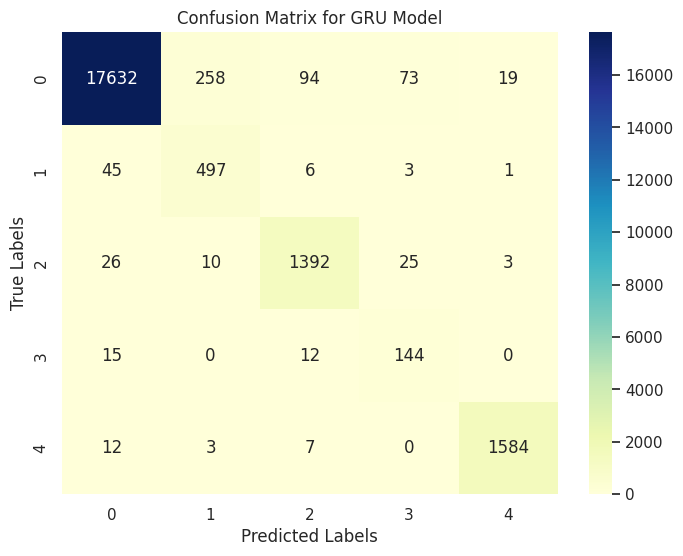

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(train_losses_2)
print(train_accuracies_2)


[0.1513718068599701, 0.07307766377925873, 0.0586206391453743, 0.050413355231285095, 0.044564008712768555, 0.04009111225605011, 0.037530507892370224, 0.03690796718001366, 0.03303192928433418, 0.03121243789792061, 0.030939841642975807, 0.028918761759996414, 0.02711072377860546, 0.02733626961708069, 0.026477018371224403, 0.026196805760264397, 0.026115819811820984, 0.024280788376927376, 0.024508928880095482, 0.023709652945399284]
[0.9480760097503662, 0.9750999808311462, 0.9800360202789307, 0.9825639724731445, 0.9847239851951599, 0.9865959882736206, 0.987280011177063, 0.9875919818878174, 0.9887440204620361, 0.989404022693634, 0.9896519780158997, 0.9901999831199646, 0.9910479784011841, 0.9908040165901184, 0.9911239743232727, 0.9911720156669617, 0.9912880063056946, 0.9918079972267151, 0.9919120073318481, 0.9920200109481812]


In [ ]:
y_pred_probs = gru_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"GRU Accuracy: {accuracy * 100:.2f}%")

In [ ]:
print(train_losses_2)
print(train_accuracies_2)

In [ ]:
DATA_ROOT

'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0'

# **Part J: DCN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from wfdb import rdsamp, rdann
import os

# Cell 1: Data Loading and Preprocessing
def load_and_preprocess_data(record_names, sequence_length=200):
    features = []
    labels = []

    for record in record_names:
        # Load signal data
        signal, fields = rdsamp(f'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{record}')
        # Load annotations
        ann = rdann(f'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{record}', 'atr')

        # Extract sequences for each beat
        for idx in range(len(ann.sample)-1):
            start = ann.sample[idx]
            end = ann.sample[idx+1]

            if end - start > sequence_length:
                # Extract fixed-length sequence
                beat = signal[start:start+sequence_length, 0]
                features.append(beat)
                labels.append(ann.symbol[idx])

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Normalize features
    scaler = StandardScaler()
    features_reshaped = features.reshape(-1, features.shape[-1])
    features_scaled = scaler.fit_transform(features_reshaped)
    features = features_scaled.reshape(features.shape)

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)

    return features, labels_onehot, label_encoder

# Cell 2: Model Definition
def create_model(sequence_length, n_classes):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(sequence_length, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Cell 3: Training and Evaluation
def train_and_evaluate_model():
    # Load data
    record_names = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234]
    sequence_length = 200
    X, y, label_encoder = load_and_preprocess_data(record_names, sequence_length)

    # Reshape for CNN input
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train model
    model = create_model(sequence_length, y.shape[1])
    epochs = 20
    train_losses_3 = []
    train_accuracies_3 = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Train for one epoch
        history = model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=32,
            verbose=0,
            validation_data=(X_test, y_test)
        )

        # Extract and store the loss and accuracy
        train_loss = history.history['loss'][0]
        train_accuracy = history.history['accuracy'][0]
        train_losses_3.append(train_loss)
        train_accuracies_3.append(train_accuracy)

        print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

    # Final evaluation
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Convert back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_test_labels = label_encoder.inverse_transform(y_test_classes)

    # Return history and predictions for visualization
    return train_losses_3, train_accuracies_3, y_test_labels, y_pred_labels

# Cell 4: Visualization
def plot_metrics(train_losses_3, train_accuracies_3, y_test, y_pred, label_encoder):
    # Plot Loss Over Epochs
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_losses_3) + 1), train_losses_3, label='Training Loss', marker='o', color='blue')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Over Epochs', fontsize=14)
    plt.grid(alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Over Epochs
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies_3) + 1), train_accuracies_3, label='Training Accuracy', marker='o', color='green')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training Accuracy Over Epochs', fontsize=14)
    plt.grid(alpha=0.4)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_names = label_encoder.classes_
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Cell 5: Main Execution
if __name__ == "__main__":
    train_losses_3, train_accuracies_3, y_test, y_pred = train_and_evaluate_model()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plot_metrics(train_losses_3, train_accuracies_3, y_test, y_pred, label_encoder)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
Epoch 1: Loss = 0.4532, Accuracy = 0.8943
Epoch 2/20
Epoch 2: Loss = 0.2467, Accuracy = 0.9390
Epoch 3/20
Epoch 3: Loss = 0.2038, Accuracy = 0.9496
Epoch 4/20
Epoch 4: Loss = 0.1809, Accuracy = 0.9544
Epoch 5/20
Epoch 5: Loss = 0.1612, Accuracy = 0.9581
Epoch 6/20
Epoch 6: Loss = 0.1494, Accuracy = 0.9612
Epoch 7/20
Epoch 7: Loss = 0.1426, Accuracy = 0.9641
Epoch 8/20
Epoch 8: Loss = 0.1303, Accuracy = 0.9659
Epoch 9/20
Epoch 9: Loss = 0.1265, Accuracy = 0.9665
Epoch 10/20
Epoch 10: Loss = 0.1210, Accuracy = 0.9681
Epoch 11/20
Epoch 11: Loss = 0.1132, Accuracy = 0.9706
Epoch 12/20
Epoch 12: Loss = 0.1108, Accuracy = 0.9700
Epoch 13/20
Epoch 13: Loss = 0.1071, Accuracy = 0.9712
Epoch 14/20
Epoch 14: Loss = 0.1005, Accuracy = 0.9729
Epoch 15/20
Epoch 15: Loss = 0.1013, Accuracy = 0.9731
Epoch 16/20
Epoch 16: Loss = 0.0962, Accuracy = 0.9737
Epoch 17/20
Epoch 17: Loss = 0.0954, Accuracy = 0.9744
Epoch 18/20
Epoch 18: Loss = 0.0934, Accuracy = 0.9742
Epoch 19/20
Epoch 19: Loss =

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'label_encoder' is not defined

In [ ]:
print(train_losses_3)
print(train_accuracies_3)

[0.4531795382499695, 0.246743306517601, 0.20378832519054413, 0.18090397119522095, 0.16119562089443207, 0.14936356246471405, 0.1426382213830948, 0.13026608526706696, 0.12645843625068665, 0.12096430361270905, 0.11318270862102509, 0.11082451045513153, 0.10712601244449615, 0.100519560277462, 0.10131755471229553, 0.09621521085500717, 0.09536882489919662, 0.09338216483592987, 0.09053108841180801, 0.08854155987501144]
[0.8942576050758362, 0.9389932751655579, 0.9496495723724365, 0.9544175267219543, 0.9581303000450134, 0.961191713809967, 0.9640577435493469, 0.9658945798873901, 0.9664938449859619, 0.9681222438812256, 0.9706234931945801, 0.9700242280960083, 0.9712488055229187, 0.9729423522949219, 0.9731377363204956, 0.9736979007720947, 0.974362313747406, 0.9741799235343933, 0.9751700162887573, 0.9758343696594238]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# Encode string labels into numerical labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Transform categories to numbers
y_pred_encoded = label_encoder.transform(y_pred)  # Transform using the same encoder

# Number of unique classes
n_classes = len(label_encoder.classes_)

# Calculate metrics
def calculate_metrics(y_test, y_pred, n_classes):
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn = np.diag(conf_matrix)  # True negatives for each class
    fp = conf_matrix.sum(axis=0) - tn  # False positives for each class
    fn = conf_matrix.sum(axis=1) - tn  # False negatives for each class
    tp = conf_matrix.sum() - (fp + fn + tn)  # True positives for each class

    # Overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')  # Same as recall
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Specificity for each class
    specificity = np.mean([tn[i] / (tn[i] + fp[i]) if (tn[i] + fp[i]) > 0 else 0 for i in range(n_classes)])

    return accuracy, sensitivity, specificity, f1

accuracy, sensitivity, specificity, f1 = calculate_metrics(y_test_encoded, y_pred_encoded, n_classes)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

# AUC-ROC Score (if y_pred contains probabilities, not strings)
# For categorical labels, this step may not apply unless using probabilities
# auc_roc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
# print(f"AUC-ROC Score: {auc_roc:.4f}")

# Decode numerical labels back to strings for report (if needed)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))


Accuracy: 0.9786
Sensitivity (Recall): 0.5298
Specificity: 0.7130
F1-Score: 0.5618

Classification Report:
              precision    recall  f1-score   support

           !       0.00      0.00      0.00         1
           "       0.92      0.99      0.95        89
           +       0.81      0.63      0.71        27
           /       0.99      0.99      0.99      1348
           A       0.95      0.67      0.78       399
           E       0.94      0.85      0.89        20
           F       1.00      0.22      0.37        49
           J       0.00      0.00      0.00        16
           L       0.99      0.99      0.99      1555
           N       0.98      1.00      0.99     12730
           Q       0.00      0.00      0.00         8
           R       0.97      0.99      0.98      1482
           V       0.95      0.98      0.97      1161
           a       1.00      0.61      0.76        23
           e       0.00      0.00      0.00         3
           f       0.95     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
DATA_ROOT

'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0'

# **Part K: SVM**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8982

Classification Report:
              precision    recall  f1-score   support

           !       0.68      0.87      0.77        79
           "       1.00      0.96      0.98        80
           +       0.66      0.66      0.66       252
           /       0.89      0.87      0.88      1421
           A       0.72      0.18      0.29       520
           E       1.00      0.33      0.50        21
           F       0.79      0.57      0.66       156
           J       0.00      0.00      0.00         8
           L       0.90      0.87      0.88      1608
           N       0.90      0.98      0.94     14994
           Q       0.00      0.00      0.00         5
           R       0.92      0.89      0.90      1422
           V       0.91      0.71      0.80      1466
           [       0.00      0.00      0.00         1
           ]       0.00      0.00      0.00         1
           a       0.00      0.00      0.00        35
           e       0.00      0.00      0

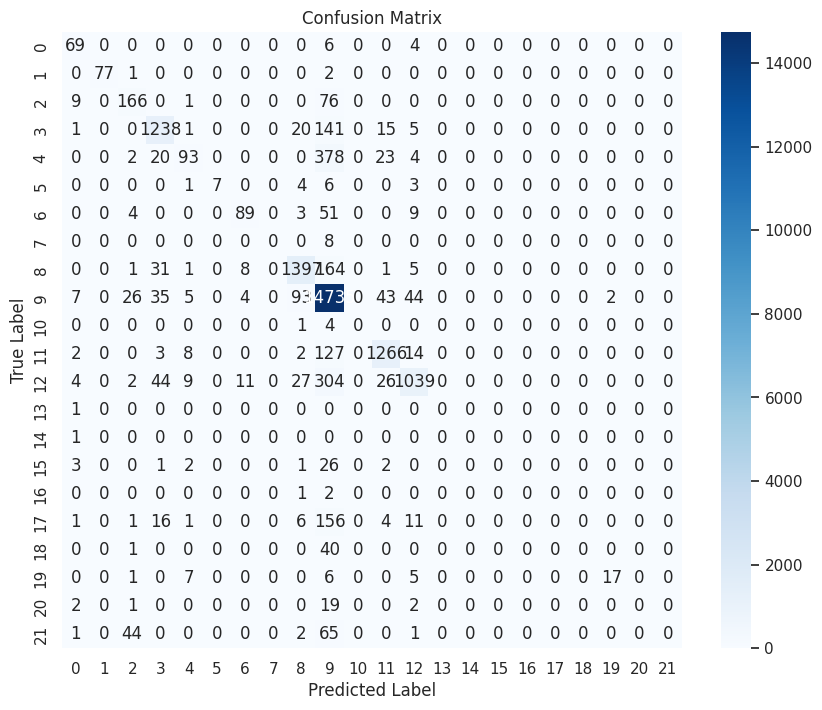

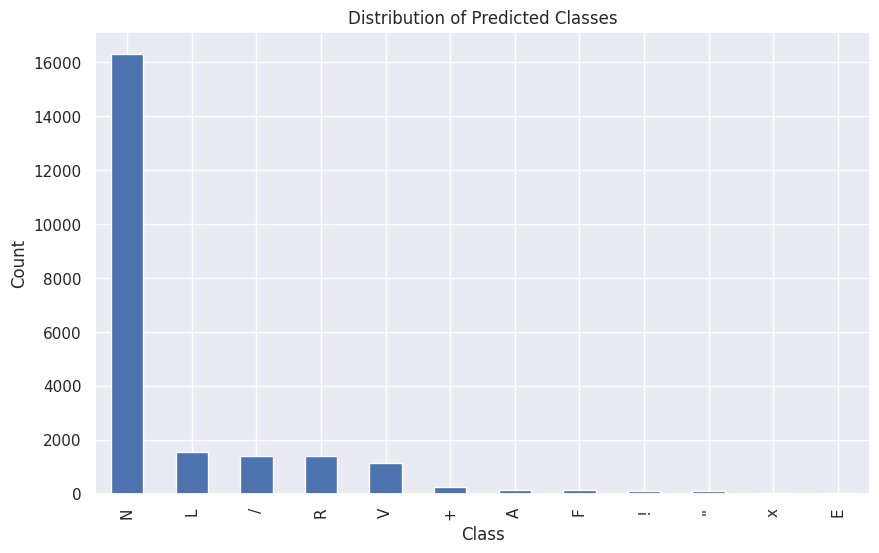

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wfdb import rdsamp, rdann
import os

# Cell 1: Data Loading and Preprocessing
def load_and_preprocess_data(record_names):
    features = []
    labels = []

    for record in record_names:
        # Load signal data
        signal, fields = rdsamp(f'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{record}')
        # Load annotations
        ann = rdann(f'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/{record}', 'atr')

        # Extract features for each beat
        for idx in range(len(ann.sample)-1):
            start = ann.sample[idx]
            end = ann.sample[idx+1]

            if end - start > 50:  # Ensure minimum beat length
                # Extract RR intervals and signal features
                beat = signal[start:end, 0]  # Channel 1

                # Basic features
                features.append([
                    np.mean(beat),
                    np.std(beat),
                    np.max(beat),
                    np.min(beat),
                    end - start,  # RR interval
                    np.median(beat),
                    np.percentile(beat, 25),
                    np.percentile(beat, 75)
                ])
                labels.append(ann.symbol[idx])

    return np.array(features), np.array(labels)

# Cell 2: Model Training and Evaluation
def train_and_evaluate_model():
    # Load data
    record_names = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234]
    X, y = load_and_preprocess_data(record_names)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM model
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, report, conf_matrix, y_test, y_pred

# Cell 3: Visualization
def plot_metrics(conf_matrix, y_test, y_pred):
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot distribution of predictions
    plt.figure(figsize=(10, 6))
    pd.Series(y_pred).value_counts().plot(kind='bar')
    plt.title('Distribution of Predicted Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Cell 4: Main Execution
if __name__ == "__main__":
    accuracy, report, conf_matrix, y_test, y_pred = train_and_evaluate_model()

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    plot_metrics(conf_matrix, y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Cell 5: Calculate Additional Metrics
def calculate_metrics(conf_matrix, y_test, y_pred):
    # Sensitivity (Recall) for each class
    recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    sensitivity = recall_per_class.mean()

    # Specificity for each class
    specificity_per_class = []
    for i in range(len(conf_matrix)):
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity_per_class.append(tn / (tn + fp))
    specificity = np.mean(specificity_per_class)

    # F1-Score (from classification report)
    f1_scores = classification_report(y_test, y_pred, output_dict=True)
    f1_score_macro = f1_scores["macro avg"]["f1-score"]

    # AUC-ROC (one-vs-rest for multi-class)
    y_test_binary = pd.get_dummies(y_test)  # One-hot encoding
    y_pred_binary = pd.get_dummies(y_pred)
    roc_auc = roc_auc_score(y_test_binary, y_pred_binary, average="macro", multi_class="ovr")

    return sensitivity, specificity, f1_score_macro, roc_auc

# Cell 6: Print Metrics
if __name__ == "__main__":

    sensitivity, specificity, f1_score_macro, roc_auc = calculate_metrics(conf_matrix, y_test, y_pred)

    print(f"\nSensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1_score_macro:.4f}")
    print(f"AUC-ROC Value: {roc_auc:.4f}")


Sensitivity (Recall): 0.3805
Specificity: 0.9889
F1-Score: 0.4038
AUC-ROC Value: 0.6444


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Part L: RNN**

In [ ]:
# MODEL BUILDING AND TRAINING - RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
Epoch 1: Loss = 1.3016, Accuracy = 0.4527
Epoch 2/20
Epoch 2: Loss = 1.3751, Accuracy = 0.3903
Epoch 3/20
Epoch 3: Loss = 1.3904, Accuracy = 0.3925
Epoch 4/20
Epoch 4: Loss = 1.4260, Accuracy = 0.3717
Epoch 5/20
Epoch 5: Loss = 1.3882, Accuracy = 0.3900
Epoch 6/20
Epoch 6: Loss = 1.3553, Accuracy = 0.4101
Epoch 7/20
Epoch 7: Loss = 1.3652, Accuracy = 0.4051
Epoch 8/20
Epoch 8: Loss = 1.3723, Accuracy = 0.3951
Epoch 9/20
Epoch 9: Loss = 1.3724, Accuracy = 0.3886
Epoch 10/20
Epoch 10: Loss = 1.2930, Accuracy = 0.4471
Epoch 11/20
Epoch 11: Loss = 1.3766, Accuracy = 0.4041
Epoch 12/20
Epoch 12: Loss = 1.3807, Accuracy = 0.4063
Epoch 13/20
Epoch 13: Loss = 1.4130, Accuracy = 0.3778
Epoch 14/20
Epoch 14: Loss = 1.3643, Accuracy = 0.4067
Epoch 15/20
Epoch 15: Loss = 1.3648, Accuracy = 0.4046
Epoch 16/20
Epoch 16: Loss = 1.4885, Accuracy = 0.3253
Epoch 17/20
Epoch 17: Loss = 1.4534, Accuracy = 0.3551
Epoch 18/20
Epoch 18: Loss = 1.4578, Accuracy = 0.3374
Epoch 19/20
Epoch 19: Loss =

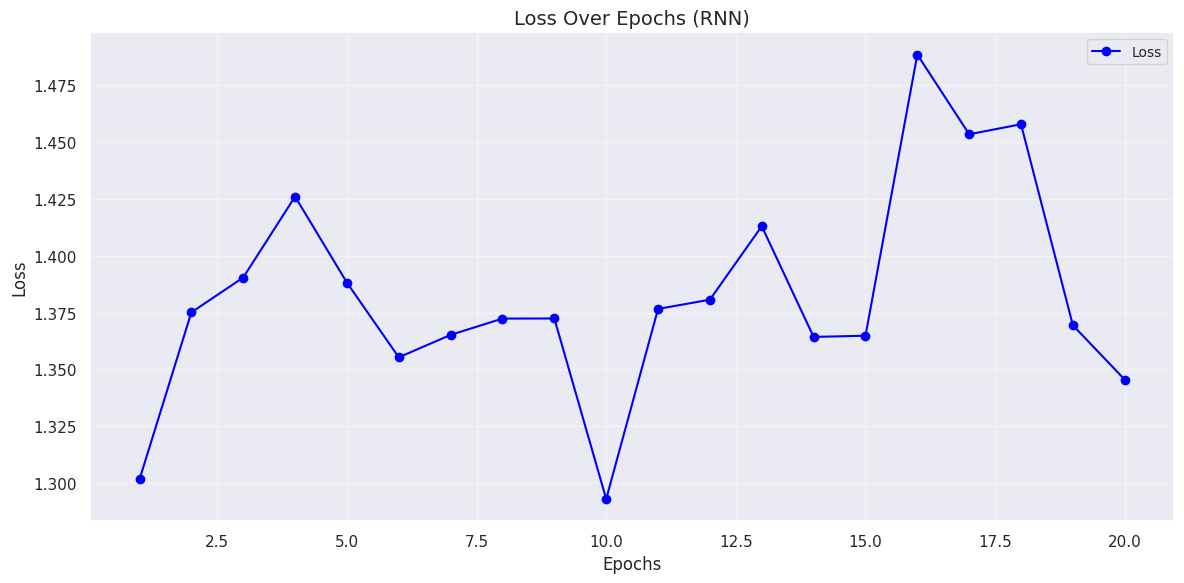

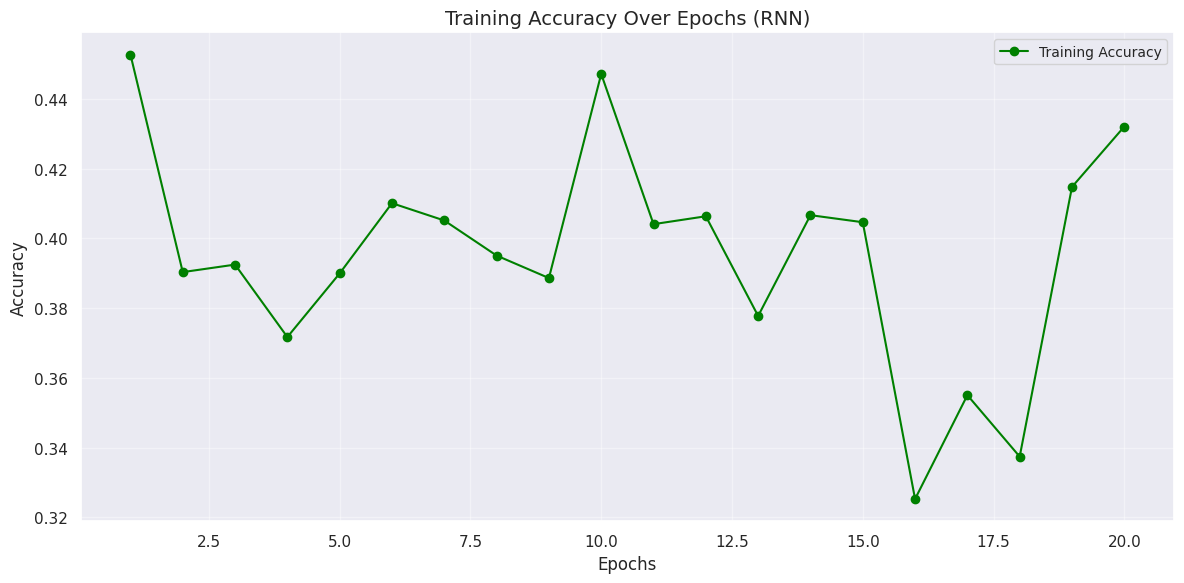

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Prepare the features and labels
X_train = train_data_r.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)  # Reshape for RNN input
y_train = tf.keras.utils.to_categorical(train_data_r.iloc[:, -1].to_numpy(), num_classes=5)

X_test = test_data.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, -1].to_numpy(), num_classes=5)

# Define the RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(300, 1), return_sequences=True, activation='tanh'),
    Dropout(0.2),
    SimpleRNN(16, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize lists to store training metrics
epochs = 20
train_losses_4 = []
train_accuracies_4 = []

# Training loop with manual logging of loss and accuracy
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train for one epoch
    history = model.fit(
        X_train,
        y_train,
        epochs=1,
        batch_size=64,  # Increased batch size
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    # Extract and store the loss and accuracy
    train_loss = history.history['loss'][0]
    train_accuracy = history.history['accuracy'][0]
    train_losses_4.append(train_loss)
    train_accuracies_4.append(train_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Plot Loss Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses_4, label='Loss', marker='o', color='blue')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Over Epochs (RNN)', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot Accuracy Over Epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_accuracies_4, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Accuracy Over Epochs (RNN)', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
print(train_losses_4)
print(train_accuracies_4)

[1.3016328811645508, 1.3750778436660767, 1.3904099464416504, 1.4260190725326538, 1.3881608247756958, 1.3553109169006348, 1.36518394947052, 1.3723496198654175, 1.3723937273025513, 1.2929747104644775, 1.3766015768051147, 1.380659818649292, 1.412985920906067, 1.3642891645431519, 1.3648078441619873, 1.4884929656982422, 1.4534311294555664, 1.4578317403793335, 1.3694016933441162, 1.3454989194869995]
[0.45271599292755127, 0.3903360068798065, 0.3924880027770996, 0.37171998620033264, 0.38996800780296326, 0.4101000130176544, 0.40513598918914795, 0.39508000016212463, 0.38863199949264526, 0.44714799523353577, 0.4040839970111847, 0.40634799003601074, 0.37775999307632446, 0.40666401386260986, 0.40463998913764954, 0.32527199387550354, 0.3550559878349304, 0.3374280035495758, 0.4147639870643616, 0.4320720136165619]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

# Get model predictions on the test data
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = y_pred_prob.argmax(axis=1)  # Predicted class labels
y_true = y_test.argmax(axis=1)       # True class labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')        # Sensitivity
f1 = f1_score(y_true, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')  # One-vs-Rest AUC-ROC

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: N/A (not defined for multi-class directly)")  # Specificity needs per-class confusion matrix
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step
Accuracy: 0.2593
Precision: 0.8087
Recall (Sensitivity): 0.2593
Specificity: N/A (not defined for multi-class directly)
F1-Score: 0.3137
AUC-ROC Score: 0.6386


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
y_pred = model.predict(X_test).argmax(axis=1)  # Predicted class labels
y_true = y_test.argmax(axis=1)                # True class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(conf_matrix.shape[0]):  # Loop through each class
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # True Negatives
    fp = np.sum(np.delete(conf_matrix[:, i], i))  # False Positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Calculate total specificity as the average
total_specificity = np.mean(specificities)

# Print total specificity
print(f"Total Specificity: {total_specificity:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step
Total Specificity: 0.8345


# **Part M: Random Forest Classifier**

In [ ]:
# MODEL BUILDING AND TRAINING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib  # For saving the trained model

In [ ]:
# Separate features (X) and labels (y)
X_train = train_data_r.iloc[:, :-1].to_numpy()
y_train = train_data_r.iloc[:, -1].to_numpy()

X_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250000, 300)
(250000,)
(21861, 300)
(21861,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

# Initialize lists to store accuracy and loss
train_accuracies_5 = []
train_losses_5 = []

# Iterate over a range of tree counts (simulating epochs)
for n_estimators in range(5, 105, 5):  # From 5 to 100 trees, step by 5
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=42,
        class_weight="balanced",
        max_depth=10
    )

    # Fit the model
    rf_model.fit(X_train, y_train)

    # Predict on training set
    y_pred_proba = rf_model.predict_proba(X_train)
    y_pred = rf_model.predict(X_train)

    # Calculate metrics
    accuracy = accuracy_score(y_train, y_pred)
    loss = log_loss(y_train, y_pred_proba)

    # Store results
    train_accuracies_5.append(accuracy)
    train_losses_5.append(loss)

    print(f"Trees: {n_estimators}, Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

# Now `train_accuracies` and `train_losses` have the simulated training progress


Trees: 5, Accuracy: 0.9286, Loss: 0.2765
Trees: 10, Accuracy: 0.9369, Loss: 0.2569
Trees: 15, Accuracy: 0.9374, Loss: 0.2591
Trees: 20, Accuracy: 0.9381, Loss: 0.2604
Trees: 25, Accuracy: 0.9379, Loss: 0.2625
Trees: 30, Accuracy: 0.9402, Loss: 0.2573
Trees: 35, Accuracy: 0.9382, Loss: 0.2619
Trees: 40, Accuracy: 0.9388, Loss: 0.2632
Trees: 45, Accuracy: 0.9397, Loss: 0.2630
Trees: 50, Accuracy: 0.9399, Loss: 0.2625
Trees: 55, Accuracy: 0.9389, Loss: 0.2637
Trees: 60, Accuracy: 0.9389, Loss: 0.2617
Trees: 65, Accuracy: 0.9390, Loss: 0.2608
Trees: 70, Accuracy: 0.9394, Loss: 0.2613
Trees: 75, Accuracy: 0.9388, Loss: 0.2624
Trees: 80, Accuracy: 0.9387, Loss: 0.2620
Trees: 85, Accuracy: 0.9384, Loss: 0.2639
Trees: 90, Accuracy: 0.9381, Loss: 0.2646
Trees: 95, Accuracy: 0.9384, Loss: 0.2644
Trees: 100, Accuracy: 0.9389, Loss: 0.2635


In [ ]:
print(train_accuracies_5)
print(train_losses_5)

[0.928648, 0.936932, 0.93738, 0.938096, 0.937872, 0.940172, 0.9382, 0.938828, 0.939712, 0.939852, 0.938928, 0.93886, 0.938964, 0.939352, 0.938844, 0.938676, 0.93842, 0.938108, 0.938364, 0.938912]
[0.27645640279511136, 0.2569024988727131, 0.2590675818971012, 0.2604365757323755, 0.2624893515922296, 0.2573349847261108, 0.2618986902172662, 0.2631501772964958, 0.26301031127104146, 0.26245459570802254, 0.263719704606082, 0.26166987935813874, 0.2607997604140337, 0.261283668148132, 0.2623881605138717, 0.26196472821313954, 0.26394551479997147, 0.2646423644548014, 0.26442096060158843, 0.26350552749178535]


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Use y_test directly if it is already in label format
y_test_labels = y_test  # Assuming y_test is a 1D array of labels
y_pred = rf_model.predict(X_test)  # Not X_train!

y_pred_labels = y_pred.argmax(axis=1) if len(y_pred.shape) > 1 else y_pred  # Ensure correct format for predictions

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Sensitivity (Recall)
recall = recall_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
specificity = sum(specificity) / len(specificity)  # Average specificity for all classes

# F1-Score
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='macro')  # Average='macro' for multi-class

# AUC-ROC
if len(rf_model.classes_) > 2:
    auc_roc = roc_auc_score(
        tf.keras.utils.to_categorical(y_test_labels, num_classes=len(rf_model.classes_)),
        rf_model.predict_proba(X_test),
        multi_class='ovr',
        average='macro'
    )
else:
    auc_roc = roc_auc_score(y_test_labels, y_pred_proba)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.9351
Sensitivity (Recall): 0.9026
Specificity: 0.9775
F1-Score: 0.7628
AUC-ROC: 0.9841
Precision: 0.7146


# **Part N: CNN+GRU**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 510s 509ms/step - accuracy: 0.5892 - loss: 0.9772 - val_accuracy: 0.8059 - val_loss: 0.6591
Epoch 2/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 502s 510ms/step - accuracy: 0.8645 - loss: 0.3665 - val_accuracy: 0.8436 - val_loss: 0.4130
Epoch 3/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 495s 507ms/step - accuracy: 0.9019 - loss: 0.2721 - val_accuracy: 0.8931 - val_loss: 0.3324
Epoch 4/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 509s 514ms/step - accuracy: 0.9182 - loss: 0.2287 - val_accuracy: 0.9156 - val_loss: 0.2684
Epoch 5/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 500s 511ms/step - accuracy: 0.9304 - loss: 0.1974 - val_accuracy: 0.9323 - val_loss: 0.2167
Epoch 6/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 492s 501ms/step - accuracy: 0.9380 - loss: 0.1754 - val_accuracy: 0.9119 - val_loss: 0.2500
Epoch 7/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 504s 504ms/step - accuracy: 0.9481 - loss: 0.1507 - val_accuracy: 0.9516 - val_loss: 0.1718
Epoch 8/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 506s 508ms/step - accuracy: 0.9533 -

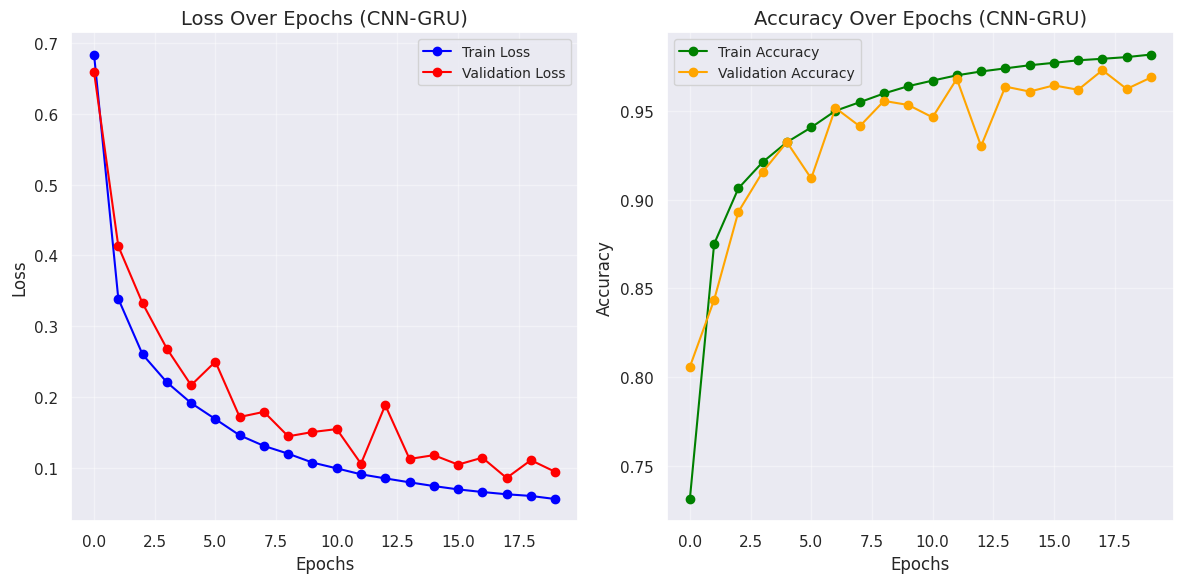

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Prepare the features and labels (assuming preprocessed train_data and test_data)
X_train = train_data_r.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)  # Reshape for CNN-GRU input
y_train = tf.keras.utils.to_categorical(train_data_r.iloc[:, -1].to_numpy(), num_classes=5)

X_test = test_data.iloc[:, :-1].to_numpy().reshape(-1, 300, 1)
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, -1].to_numpy(), num_classes=5)

# Define the Hybrid CNN-GRU model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(300, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    GRU(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    GRU(32, activation='tanh'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Metrics
accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
classification_metrics = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(5)])
auc_roc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))
specificity = sum(specificity) / len(specificity)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_metrics)
print(f"Specificity: {specificity:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='red')
plt.title('Loss Over Epochs (CNN-GRU)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='orange')
plt.title('Accuracy Over Epochs (CNN-GRU)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

In [74]:
# Lists to store training accuracy and loss
training_accuracy_6 = history.history['accuracy']
training_loss_6 = history.history['loss']


# Print or inspect the saved values
print("Training Accuracy per Epoch:", training_accuracy_6)
print("Training Loss per Epoch:", training_loss_6)


Training Accuracy per Epoch: [0.7314680218696594, 0.8750720024108887, 0.9063519835472107, 0.9211040139198303, 0.9322919845581055, 0.9406239986419678, 0.9499679803848267, 0.9548079967498779, 0.9597359895706177, 0.9638320207595825, 0.9669719934463501, 0.9699320197105408, 0.972104012966156, 0.9738559722900391, 0.9756039977073669, 0.976967990398407, 0.9783959984779358, 0.9792519807815552, 0.980184018611908, 0.9816240072250366]
Training Loss per Epoch: [0.6837608814239502, 0.3387419879436493, 0.2601527273654938, 0.2208278626203537, 0.19147691130638123, 0.16880472004413605, 0.14594684541225433, 0.13096076250076294, 0.11996273696422577, 0.10743388533592224, 0.09924870729446411, 0.09084556251764297, 0.08506811410188675, 0.07954054325819016, 0.07425831258296967, 0.06953825801610947, 0.06584859639406204, 0.06265662610530853, 0.06029604747891426, 0.05593286082148552]


In [75]:
# Calculate Metrics
accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
classification_metrics = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(5)], output_dict=True)

# Extract key metrics for each class and compute averages
precision = classification_metrics['weighted avg']['precision']
recall = classification_metrics['weighted avg']['recall']  # Sensitivity
f1_score = classification_metrics['weighted avg']['f1-score']

# AUC-ROC score (multi-class, OVR)
auc_roc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')

# Confusion Matrix for Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
specificity_list = []
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity_list.append(tn / (tn + fp))
specificity = sum(specificity_list) / len(specificity_list)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")


684/684 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step
Accuracy: 0.9728
Precision: 0.9800
Recall (Sensitivity): 0.9728
Specificity: 0.9914
F1-Score: 0.9751
AUC-ROC Score: 0.9959


In [ ]:
x_train = np.load("/content/drive/My Drive/colab_data/x_train.npy")
y_train = np.load("/content/drive/My Drive/colab_data/y_train.npy")
x_test = np.load("/content/drive/My Drive/colab_data/x_test.npy")
y_test = np.load("/content/drive/My Drive/colab_data/y_test.npy")

print("Data loaded successfully!")

In [ ]:
#PAPER VALUES

In [ ]:
#MODEL 1 = LOGISTIC REGRES

In [76]:
one_acc=[0.794304, 0.800276, 0.803896, 0.805656, 0.806976, 0.807856, 0.808732, 0.80934, 0.809764, 0.810168, 0.81074, 0.811148, 0.811532, 0.811916, 0.812248, 0.812464, 0.812692, 0.812864, 0.813036, 0.813248]
one_loss=[0.6445234824104497, 0.6147749791914167, 0.6006380345022148, 0.5920020036225159, 0.5860385526743657, 0.5816085477056596, 0.5781547071315788, 0.5753674799328671, 0.5730589920463206, 0.5711075743563548, 0.5694304403446514, 0.5679690294216484, 0.5666806025160411, 0.5655331584484312, 0.5645022221866757, 0.563568740589149, 0.562717659077454, 0.5619369304664663, 0.5612168064367259, 0.5605493196688047]

In [ ]:
#MODEL 2 = GRU

In [77]:
two_acc=[0.9497519731521606, 0.9758279919624329, 0.9812600016593933, 0.9837639927864075, 0.985696017742157, 0.9863479733467102, 0.9879559874534607, 0.9880759716033936, 0.988752007484436, 0.9893879890441895, 0.9901120066642761, 0.9901599884033203, 0.9907640218734741, 0.991100013256073, 0.9912199974060059, 0.991599977016449, 0.9919080138206482, 0.9922879934310913, 0.9921960234642029, 0.9922239780426025]
two_loss=[0.14878958463668823, 0.07200867682695389, 0.056406162679195404, 0.048450976610183716, 0.04321490600705147, 0.04130982980132103, 0.03690203279256821, 0.036017414182424545, 0.03378511220216751, 0.0316888727247715, 0.029825177043676376, 0.029907753691077232, 0.027822384610772133, 0.02693835459649563, 0.02631307952105999, 0.025469766929745674, 0.024269184097647667, 0.022758042439818382, 0.024006668478250504, 0.023401865735650063]


In [ ]:
#MODEL 3 = DCN

In [78]:
three_acc= [0.9032203555107117, 0.9475651979446411, 0.9554336667060852, 0.9600713849067688, 0.9637972116470337, 0.9653865098953247, 0.967783510684967, 0.9691383838653564, 0.9715223908424377, 0.9720825552940369, 0.9729944467544556, 0.9741538763046265, 0.9747922420501709, 0.9759255647659302, 0.97535240650177, 0.9763815402984619, 0.9773325324058533, 0.9772152900695801, 0.9774628281593323, 0.9773455858230591]
three_loss=[0.41855117678642273, 0.22164642810821533, 0.17985156178474426, 0.15785396099090576, 0.14300638437271118, 0.13527639210224152, 0.12533311545848846, 0.11833655834197998, 0.11016669869422913, 0.10589313507080078, 0.09986422210931778, 0.09738669544458389, 0.09607178717851639, 0.08970153331756592, 0.08936809003353119, 0.08444444835186005, 0.0816313847899437, 0.08269838243722916, 0.07999605685472488, 0.07918395102024078]

In [ ]:
#MODEL 4 = RNN

In [79]:
four_acc=[0.5418639779090881, 0.466264009475708, 0.514739990234375, 0.5426599979400635, 0.5120279788970947, 0.5039600133895874, 0.43688398599624634, 0.5344039797782898, 0.606719970703125, 0.4727320075035095, 0.4930639863014221, 0.4690600037574768, 0.4907039999961853, 0.4286639988422394, 0.4127880036830902, 0.4194200038909912, 0.41579198837280273, 0.43505600094795227, 0.4391759932041168, 0.48278799653053284]
four_loss=[1.1448893547058105, 1.265896201133728, 1.183169960975647, 1.129708170890808, 1.1857260465621948, 1.1846650838851929, 1.3111339807510376, 1.134522557258606, 1.0135095119476318, 1.2708361148834229, 1.2248022556304932, 1.2640950679779053, 1.2589040994644165, 1.3540977239608765, 1.3647104501724243, 1.33812415599823, 1.3475987911224365, 1.3484597206115723, 1.3219703435897827, 1.2400301694869995]

In [ ]:
#MODEL 5 = RANDOM FOREST

In [80]:
five_acc=[0.922036, 0.933372, 0.934248, 0.9338, 0.934548, 0.937436, 0.937244, 0.937412, 0.937732, 0.937908, 0.937784, 0.937872, 0.939476, 0.940776, 0.939736, 0.939224, 0.938128, 0.93852, 0.938712, 0.938576]
five_loss=[0.28170702572103173, 0.2682897313365634, 0.26553924025999387, 0.2692522748300807, 0.2683229381515832, 0.26224909559317294, 0.26128089037323604, 0.26258238514786864, 0.2633626300087603, 0.2628886475525811, 0.26186480355941716, 0.26208538989936586, 0.26042096680500626, 0.2586163186462855, 0.26087766636482357, 0.2621051306043934, 0.2633422968003297, 0.2638200199472451, 0.26364201487199423, 0.26331292115350935]


In [ ]:
#MODEL 6 = CNN+GRU

In [81]:
six_acc=[0.728663980960846, 0.8683159947395325, 0.9056599736213684, 0.9265639781951904, 0.940123975276947, 0.9488760232925415, 0.9542120099067688, 0.9581519961357117, 0.9631239771842957, 0.9657599925994873, 0.968288004398346, 0.9703879952430725, 0.9719120264053345, 0.9741320013999939, 0.9760040044784546, 0.9774960279464722, 0.9791039824485779, 0.9798640012741089, 0.9812600016593933, 0.9813479781150818]
six_loss= [0.6932276487350464, 0.3514583706855774, 0.2621152102947235, 0.213726207613945, 0.17899492383003235, 0.15392258763313293, 0.13922566175460815, 0.12570008635520935, 0.11237394064664841, 0.10492122918367386, 0.09623057395219803, 0.09030167758464813, 0.08533963561058044, 0.07904238253831863, 0.07313830405473709, 0.06923767179250717, 0.06401797384023666, 0.06180613487958908, 0.05836976319551468, 0.0568392314016819]

In [ ]:
#MODEL 7 = CAT

In [82]:
seven_acc=[0.9273675680160522, 0.975141167640686, 0.9823886752128601, 0.9860767722129822, 0.9879779815673828, 0.9887784719467163, 0.990050733089447, 0.990608274936676, 0.9912943840026855, 0.9919948577880859, 0.9919233918190002, 0.9926953315734863, 0.9938532114028931, 0.993524432182312, 0.9943535327911377, 0.9942248463630676, 0.9951969385147095, 0.9947251677513123, 0.9951111674308777, 0.9956114888191223]
seven_loss=[0.26658445596694946, 0.09346409887075424, 0.06378432363271713, 0.05237242206931114, 0.0438242070376873, 0.03878050297498703, 0.03539082780480385, 0.03130434453487396, 0.0280882827937603, 0.025061020627617836, 0.025613343343138695, 0.02202187478542328, 0.019231267273426056, 0.020014600828289986, 0.016758129000663757, 0.01765352487564087, 0.014806714840233326, 0.016089661046862602, 0.015069253742694855, 0.013026365078985691]

In [83]:
print(len(one_acc), len(two_acc), len(three_acc), len(four_acc), len(five_acc), len(six_acc), len(seven_acc))
print(len(one_loss), len(two_loss), len(three_loss), len(four_loss), len(five_loss), len(six_loss), len(seven_loss))

20 20 20 20 20 20 20
20 20 20 20 20 20 20


In [ ]:
DATA_ROOT

'/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0'

In [84]:
import matplotlib.pyplot as plt

training_accuracies = [
    one_acc, two_acc, three_acc, four_acc, five_acc, six_acc, seven_acc
]
training_losses = [
    one_loss, two_loss, three_loss, four_loss, five_loss, six_loss, seven_loss
]

# Model labels for the legend
model_labels = [
    "Logistic Regression", "GRU", "DCN", "RNN", "Random Forest", "CNN+GRU", "CAT"
]

# Use only even-numbered epochs
epochs = list(range(2, 21, 2))

# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc[:len(epochs)], label=model_labels[i])  # Slice acc data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'/content/drive/MyDrive/training_accuracies.png', dpi=300)
plt.close()

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss[:len(epochs)], label=model_labels[i])  # Slice loss data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(r'/content/drive/MyDrive/training_losses.png', dpi=300)
plt.close()

print("Plots saved as 'training_accuracies.png' and 'training_losses.png'")


Plots saved as 'training_accuracies.png' and 'training_losses.png'


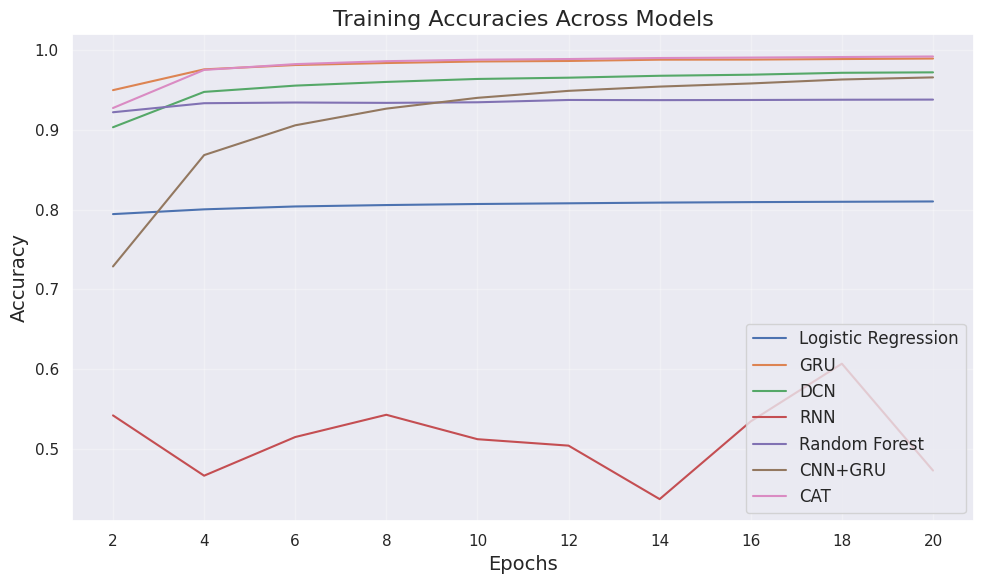

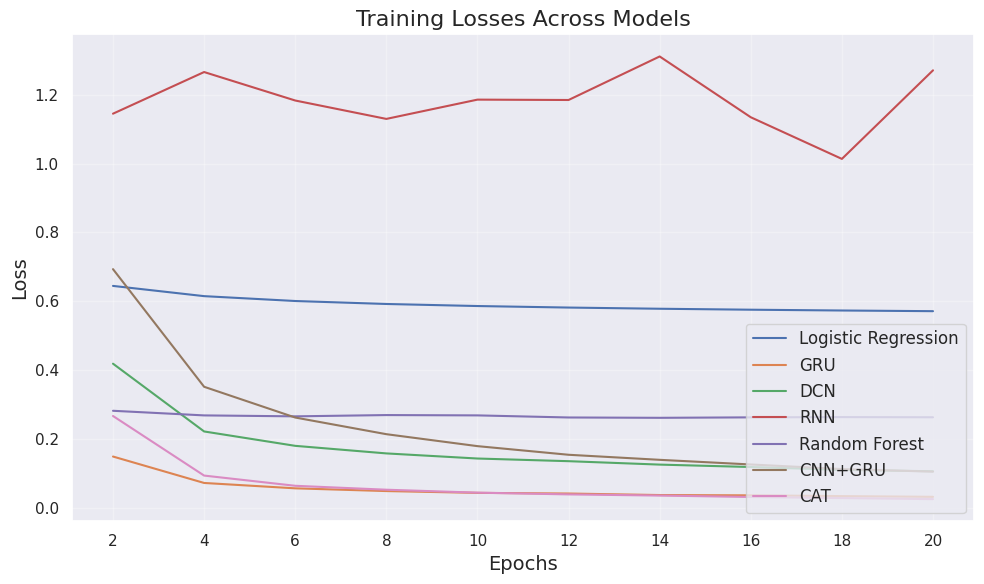

In [85]:
import matplotlib.pyplot as plt

training_accuracies = [
    one_acc, two_acc, three_acc, four_acc, five_acc, six_acc, seven_acc
]
training_losses = [
    one_loss, two_loss, three_loss, four_loss, five_loss, six_loss, seven_loss
]

# Model labels for the legend
model_labels = [
    "Logistic Regression", "GRU", "DCN", "RNN", "Random Forest", "CNN+GRU", "CAT"
]

# Use only even-numbered epochs
epochs = list(range(2, 21, 2))

# Plot Training Accuracies
plt.figure(figsize=(10, 6))
for i, acc in enumerate(training_accuracies):
    plt.plot(epochs, acc[:len(epochs)], label=model_labels[i])  # Slice acc data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Accuracies Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save and Display
plt.savefig('training_accuracies.png', dpi=300)
plt.show()  # Show in Colab

# Plot Training Losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(training_losses):
    plt.plot(epochs, loss[:len(epochs)], label=model_labels[i])  # Slice loss data
plt.xticks(epochs)  # Set x-axis ticks to whole numbers
plt.title('Training Losses Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save and Display
plt.savefig('training_losses.png', dpi=300)
plt.show()  # Show in Colab
